In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
import os
from urllib.request import urlretrieve as download
from glob import glob as g
from Bio.Blast import NCBIWWW, NCBIXML
from mypdb import PDB_file as mypdb
from Bio.Blast.Applications import NcbipsiblastCommandline
from time import time as t
from tqdm import tqdm


import glob
import xml.etree.ElementTree as ET
from collections import defaultdict

import re
import MDAnalysis as mda
from time import time as t

In [ ]:
#Class to handle and download the hits from a blast search



def merge_dicts(dict1, dict2):
    for k2, v2 in dict2.items():
        if k2 in dict1:
            if isinstance(dict1[k2], list):
                dict1[k2].append(v2)
            else:
                dict1[k2] = [dict1[k2], v2]
        else:
            print(f"New Key : {k2}")
            dict1[k2] = v2
    return dict1

class hit:
    def __init__(self, xml_hit):
        self.hit_num = xml_hit[0].text
        pdb_info = xml_hit[1].text.split("|")[1:]
        self.pdb_id = pdb_info[0]
        self.pdb_chain = pdb_info[1]
        self.description = xml_hit[2].text
        data = [[y.tag.replace("Hsp_", ""), y.text] for y in xml_hit[5][0]]
        self.data = dict(data)
        self.pdb = None
        self._not_exists = False

    @staticmethod
    def download2(code, pdir=None):
        base_url = "https://files.rcsb.org/download"
        pdb_url = f"{base_url}/{code}.pdb"
        f_p = os.path.join(pdir, f"{code}.pdb")
        try:
            download(pdb_url, f_p)
            return f_p  # Return the file path if succeeded
        except Exception:
            print(f"File {code} not found.")
            return None  # Return None if failed

    def _assign(self, f_p):
        self.pdb_path = f_p
        self.pdb = mypdb(f_p)
        
    def check_for_pdb(self, pdir=None):
        if pdir is None:
            pdir = "./pdbs/"
        elif pdir[-1] != "/":
            pdir += "/"
        if not os.path.isdir(pdir):
            os.makedirs(pdir, exist_ok=True)
        matches = g(pdir + f"{self.pdb_id}*")
        if matches:
            if not self.pdb:
                self._assign(matches[0])
            return True
        else:
            return False

In [ ]:
#Class to handle the blast search
class blast:
    def __init__(self, sequence, name, database, path, program="blastp", hitlen=10000):
        self.sequence = sequence
        self.program = program
        self.database = database
        self.path = path
        self.name = name
        self.hitlen = hitlen

        if program == "blastp" and (self.path and os.path.isfile(self.path)):
            self.parse_search()
        elif program == "psiblast":
            self.psiblast_search()
        else:
            self.bsearch()

    def bsearch(self):
        # Perform the initial BLASTP search
        if self.program == "blastp":
            print("Searching BLASTP...")
            t1 = t()
            self.results = NCBIWWW.qblast(self.program, self.database, self.sequence, hitlist_size=self.hitlen)
            t2 = t()
            print(f"BLASTP took {round(t2-t1,4)} seconds")
            if not self.path:
                self.path = f"{self.name}-blast.xml"
            with open(self.path, "w") as output_xml:
                output_xml.write(self.results.read())
            self.parse_search()

    def psiblast_search(self):
        # Run local PSI-BLAST using NcbipsiblastCommandline
        print(f"Running PSI-BLAST on {self.name}...")
        input_fasta = f"{self.name}.fasta"
        with open(input_fasta, "w") as f:
            f.write(f">query\n{self.sequence}\n")

        psiblast_cline = NcbipsiblastCommandline(
            query=input_fasta,
            db="/home/marmatt/ncbi-blast-2.16.0+/bin/pdbaa",
            evalue=10,
            num_iterations=3,
            out_ascii_pssm=f"{self.name}.pssm",
            out=f"{self.name}-psiblast.xml",
            outfmt=5
        )
        stdout, stderr = psiblast_cline()
        if stderr:
            print(f"PSI-BLAST ERROR: {stderr}")
        else:
            print("PSI-BLAST search completed.")
            self.parse_search(xml_file=f"{self.name}-psiblast.xml")

    def parse_search(self, xml_file=None):
        xml_file = xml_file or self.path
        if not xml_file:
            raise Exception("No XML file path provided.")
        t1 = t()
        tree = ET.parse(xml_file)
        iteration = tree.findall("./BlastOutput_iterations/Iteration/")
        self.query_length = iteration[3].text
        hits = [hit(x) for x in iteration[-2]] #returns hit objects
        self.hits = hits
        mega_dict = hits[0].data
        for x in hits[1:]:
            mega_dict = merge_dicts(mega_dict, x.data)
        mega_dict["PDB ID"] = [x.pdb_id for x in hits]
        mega_dict["Chain"] = [x.pdb_chain for x in hits]
        mega_dict["Description"] = [x.description for x in hits]
        self.df = pd.DataFrame.from_dict(mega_dict)
        print(self.df)
        t2 = t()
        print(f"Time taken to parse {t2-t1}")
    
    def download_pdbs(self, pdir=None):
        default_dir = "./PDBs"
        pdir = os.path.abspath(pdir if pdir else default_dir)
        if not os.path.isdir(pdir):
            os.makedirs(pdir, exist_ok=True)
        
        files = [os.path.splitext(f)[0] for f in os.listdir(pdir)]
        hit_bar = tqdm(self.hits, desc="Processing Hits")
        
        for x in hit_bar:
            if x.pdb_id not in files:
                hit_bar.set_description(f"Downloading {x}")
                
                try:
                    file_path = x.download2(x.pdb_id, pdir=pdir)

                    if file_path:
                        x._assign(file_path)
                    else:
                        # In case download2 does not return a valid path
                        raise Exception("Download failed")
                except Exception as e:
                    # Print a message if download fails or file path is invalid
                    print(f"Structure {x.pdb_id} was not found...")

## Actually running the blast search

In [ ]:

"""
Here we perform a blast search on:
 1.   The BRAF monomer
"""
with open("./fastas.txt") as f:
    fastas = f.readlines()

braf_fasta = fastas[1]
name = "braf"

# Directory for storing blast search results
output_dir = "./blast_search"
# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

res_path = os.path.join(output_dir, f"{name}-blast.xml")  # Path for the results file

# Check for saved results in the specified directory
if os.path.exists(res_path):
    bs = blast(braf_fasta, name, database="pdb", path=res_path)
else:
    bs = blast(braf_fasta, name, database="pdb", path=None)

bs.download_pdbs()

## Counting the number of pdb files in the directory

In [ ]:


import glob
def count_pdb_files(directory):
    # Ensure the directory path ends with a slash
    directory = os.path.join(directory, '')

    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Return the count of .pdb files
    return len(pdb_files)

# Specify the directory
pdb_directory = 'PDBs'

# Get the count of PDB files
pdb_count = count_pdb_files(pdb_directory)

print(f"There are {pdb_count} PDB files in the directory '{pdb_directory}'.")

## Counting the number of pdb hits in the xml file and checking which ones have not been downloaded


In [ ]:


def count_pdb_files(directory):
    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Extract the base filenames (without extension) to compare with PDB IDs
    pdb_file_ids = {os.path.splitext(os.path.basename(f))[0] for f in pdb_files}

    return pdb_file_ids

def find_unique_and_duplicate_pdb_hit_ids(xml_file):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Dictionary to count occurrences of each PDB hit ID
    hit_id_counts = defaultdict(int)

    # Iterate over all Hit elements in the XML
    for hit in root.findall('.//Hit'):
        # Extract the Hit_id text
        hit_id = hit.find('Hit_id').text

        # Assuming the Hit_id format is 'pdb|PDB_ID|Chain', extract the PDB_ID
        pdb_id = hit_id.split('|')[1]

        # Increment the count for this PDB_ID
        hit_id_counts[pdb_id] += 1

    # Find all PDB IDs (unique and duplicates)
    all_hit_ids = set(hit_id_counts.keys())

    return all_hit_ids

# Specify the directory and XML file
pdb_directory = 'PDBs'
xml_file = 'braf-blast.xml'

# Get the PDB file IDs from the directory
pdb_file_ids = count_pdb_files(pdb_directory)

# Get all PDB hit IDs from the XML
all_pdb_ids = find_unique_and_duplicate_pdb_hit_ids(xml_file)

# Calculate the number of total PDB hits
total_pdb_hits = len(all_pdb_ids)

# Find PDB IDs in XML that are not in the directory
missing_pdb_ids = all_pdb_ids - pdb_file_ids

print(f"There are {total_pdb_hits} total PDB hits in the file '{xml_file}'.")
print(f"There are {len(missing_pdb_ids)} PDB IDs in the XML not found in the directory '{pdb_directory}':")
print(missing_pdb_ids)


## Here we are stripping the downloaded pdb files to only contain the chain of interest


In [ ]:
import os
from glob import glob
import re
import MDAnalysis as mda
from time import time as t
!ls
def sglob(fp, absolute=True):
    fps = sorted(glob(fp))
    if absolute:
        fps = [os.path.abspath(f) for f in fps]
    return fps

def strip_to_chain(pdb_file, chain_ID):
    u = mda.Universe(pdb_file)
    print(f"Loaded trajectory from {pdb_file} with {len(u.atoms)} atoms.")

    chain = u.select_atoms(f"protein and chainID {chain_ID}")
    if len(chain) == 0:
        print(f"Chain {chain_ID} not found in {pdb_file}.")
        return None
    return chain

def post_process(fname):
    with open(fname, "r") as f_o:
        initial_lines = f_o.readlines()

    print(f"File {fname} before post_process, first few lines:")
    print("".join(initial_lines[:20]))

    final_lines = initial_lines[-2:].copy()
    no_ter = [line for line in initial_lines if line[:3] != "TER" or line in final_lines]

    if len(no_ter) != len(initial_lines):
        with open(fname, "w") as f_o:
            print(f"Rewriting {fname}, lines reduced from {len(initial_lines)} to {len(no_ter)}")
            f_o.write("".join(no_ter))

    print(f"File {fname} after post_process, first few lines:")
    with open(fname, "r") as f_r:
        print("".join(f_r.readlines()[:20]))

def parse_xml(xml_file):
    hit_id = re.compile(r"<Hit_id>(.*?)<.Hit_id>")
    with open(xml_file, "r") as f:
        text = f.read()
        results = [h.split("|")[1:] for h in hit_id.findall(text)]
        pdb_chain_dict = {}
        for r in results:
            pdb_chain_dict[r[0]+f"_{r[1]}"] = r[1]
    return pdb_chain_dict

def get_pdb_id(fp):
    fp = fp.rsplit(".", 1)[0]
    if "/" in fp:
        fp = fp.rsplit("/", 1)[1]
    return fp

def target_name(fp, target_dir, chain):
    orig_path, file_name = fp.rsplit("/", 1)
    fp = fp.replace(orig_path, target_dir)
    fp = fp.split(".")[0] + f"_{chain}.pdb"
    return fp

def find_pdb_file(PDB_chain_id, files):
    print(files)
    if "_" in PDB_chain_id:
        PDB_id = PDB_chain_id.split("_")[0]
    assert len(PDB_id) == 4
    for f in files:
        filename = os.path.basename(f).split('.')[0]
        if filename.startswith(PDB_id):
            print(f"Found file: {f} for PDB ID: {PDB_id}")
            return f

print("BEGIN")
t1 = t()
xml = "braf-blast.xml"
pdb_dir = "PDBs"
target_dir = "Results/activation_segments/unaligned"

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

xml_chain_dict = parse_xml(xml)
print(xml_chain_dict)

pdb_files = sorted(sglob("PDBs/*.pdb"))
print(pdb_files)
keys = sorted([*xml_chain_dict.keys()], key=get_pdb_id)

print(keys)
files = [find_pdb_file(k, pdb_files) for k in keys]
print(files)
chain_IDs = [xml_chain_dict[k] for k in keys]
print(len(chain_IDs))

valid_file_chain_pairs = [(f, c) for f, c in zip(files, chain_IDs) if f is not None]
print(len(valid_file_chain_pairs))
new_file_paths = [target_name(f, target_dir, c) for f, c in valid_file_chain_pairs]
print(new_file_paths)
file_paths = [f for f, c in valid_file_chain_pairs]
print(file_paths)
print(len(file_paths))

for (fp, chain_ID, tp) in zip(file_paths, chain_IDs, new_file_paths):
    if fp is not None:
        try:
            print(fp, chain_ID, tp)
            chain = strip_to_chain(fp, chain_ID)
            if chain is not None:
                with mda.Writer(tp) as w:
                    w.write(chain)
                post_process(tp)
        except Exception as e:
            print(f"An error occurred while processing {fp} with chain {chain_ID}: {e}")
        
t2 = t()
t_t = round(t2 - t1, 3) // 60
t_t = str((t_t // 60)) + ":" + str(t_t % 60)
print(f"Time taken {t_t} for sequential processing")


## Counting again how many pdb files are in the directory after stripping the chains

In [ ]:
import glob

def count_pdb_files(directory):
    # Ensure the directory path ends with a slash
    directory = os.path.join(directory, '')

    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Return the count of .pdb files
    return len(pdb_files)

# Specify the directory
pdb_directory = 'Results/activation_segments/unaligned'

# Get the count of PDB files
pdb_count = count_pdb_files(pdb_directory)

print(f"There are {pdb_count} PDB files in the directory '{pdb_directory}'.")

In [ ]:
#Extracting the full sequence from the pdb files, checking if there are any non-natural amino acids and substituting them and selecting only sequences with a maximum gap length of 4 amino acids to be reconstructed
from Bio.PDB import PDBParser, PPBuilder
from Bio.SeqUtils import seq1
from glob import glob
from tqdm import tqdm
import os

def substitute_non_natural_amino_acid(residue, aligned_atom, index):
    """Substitute non-natural amino acids with their natural counterparts."""
    substitutions = {
        'X': 'G',  # Glycine
        'B': 'N',  # Asparagine
        'Z': 'Q',  # Glutamine
        'J': 'L'   # Leucine
    }
    
    if residue == 'X':
        # Check if 'X' is surrounded by missing amino acids in aligned_atom
        if index > 0 and aligned_atom[index - 1] == '-':
            return residue
        if index < len(aligned_atom) - 1 and aligned_atom[index + 1] == '-':
            return residue

    return substitutions.get(residue, residue)

def extract_seqres_sequence(pdb_file):
    """Extract SEQRES sequences for each chain from a PDB file."""
    seq_dict = {}
    with open(pdb_file, "r") as file:
        lines = file.readlines()

    current_chain = None
    current_seq = []

    for line in lines:
        if line.startswith("SEQRES"):
            parts = line.split()
            chain_id = parts[2]
            if chain_id != current_chain:
                if current_chain is not None:
                    seq_dict[current_chain] = ''.join(seq1(residue) for residue in current_seq)
                current_chain = chain_id
                current_seq = []
            current_seq.extend(parts[4:])

    if current_chain is not None:
        seq_dict[current_chain] = ''.join(seq1(residue) for residue in current_seq)

    return seq_dict

def extract_atom_sequence(pdb_file, chain_id):
    """Extract sequence from atomic coordinates for a specific chain."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    for model in structure:
        chain = model[chain_id]
        
        ppb = PPBuilder()
        sequence = ''
        for pp in ppb.build_peptides(chain):
            sequence += pp.get_sequence()
        return sequence
    return None

def find_motif_indices(sequence, motif):
    """Find the start index of a motif in a sequence."""
    index = sequence.find(motif)
    return index if index != -1 else None

def align_and_highlight_gaps(seqres_segment, atom_segment):
    """Align SEQRES and ATOM segments and highlight gaps in ATOM."""
    aligned_seqres = ''
    aligned_atom = ''
    atom_index = 0
    max_gap_length = 0
    current_gap_length = 0

    for res_seqres in seqres_segment:
        if atom_index < len(atom_segment) and res_seqres == atom_segment[atom_index]:
            aligned_seqres += res_seqres
            aligned_atom += atom_segment[atom_index]
            atom_index += 1
            current_gap_length = 0
        else:
            aligned_seqres += res_seqres
            aligned_atom += '-'
            current_gap_length += 1
            max_gap_length = max(max_gap_length, current_gap_length)

    return aligned_seqres, aligned_atom, max_gap_length

def main():
    target_dir = "Results/activation_segments/unaligned"
    pdb_dir = "PDBs"
    fasta_output_file = "seqres_sequences.fasta"  # File to store full sequences
    text_output_file = "seqres_info.txt"
    aligned_sequences = {}
    satisfying_structures_count = 0

    pdb_files = glob(os.path.join(target_dir, "*.pdb"))

    with open(text_output_file, "w") as text_output, open(fasta_output_file, "w") as fasta_output:
        for pdb_file in tqdm(pdb_files, desc="Processing PDB files"):
            pdb_name = os.path.basename(pdb_file)
            pdb_id, chain_id_file = os.path.splitext(pdb_name)[0].split('_')
            chain_id = chain_id_file

            full_pdb_path = os.path.join(pdb_dir, pdb_id + '.pdb')
            if not os.path.isfile(full_pdb_path):
                print(f"Corresponding full PDB for {pdb_id} not found.")
                continue

            seqres_seqs = extract_seqres_sequence(full_pdb_path)
            atom_seq = extract_atom_sequence(full_pdb_path, chain_id)

            if chain_id in seqres_seqs and atom_seq:
                seqres_sequence = seqres_seqs[chain_id]
                seqres_dfg_index = find_motif_indices(seqres_sequence, 'DFG')
                seqres_ape_index = find_motif_indices(seqres_sequence, 'APE')
                atom_dfg_index = find_motif_indices(atom_seq, 'DFG')
                atom_ape_index = find_motif_indices(atom_seq, 'APE')

                # Determine the start and end indices for the segments
                if None not in [seqres_dfg_index, seqres_ape_index, atom_dfg_index, atom_ape_index]:
                    seqres_start = min(seqres_dfg_index, seqres_ape_index)
                    seqres_end = max(seqres_dfg_index + 3, seqres_ape_index + 3)
                    atom_start = min(atom_dfg_index, atom_ape_index)
                    atom_end = max(atom_dfg_index + 3, atom_ape_index + 3)

                    seqres_segment = seqres_sequence[seqres_start:seqres_end]
                    atom_segment = atom_seq[atom_start:atom_end]

                    aligned_seqres, aligned_atom, max_gap_length = align_and_highlight_gaps(seqres_segment, atom_segment)
                    
                    # Check for differences and substitute non-natural amino acids
                    exclude_due_to_non_natural_diff = False
                    corrected_seqres = ''
                    for index, (res_seqres, res_atom) in enumerate(zip(aligned_seqres, aligned_atom)):
                        if res_seqres != res_atom:
                            corrected_residue = substitute_non_natural_amino_acid(res_seqres, aligned_atom, index)
                            corrected_seqres += corrected_residue
                            if corrected_residue != res_seqres:
                                print(f"Substituting non-natural amino acid '{res_seqres}' with '{corrected_residue}' in SEQRES for {pdb_id}_{chain_id}.")
                        else:
                            corrected_seqres += res_seqres

                    if not exclude_due_to_non_natural_diff and max_gap_length <= 4:
                        satisfying_structures_count += 1
                        info = (f"Aligned Sequences for {pdb_id}_{chain_id}: (Max gap length: {max_gap_length})\n"
                                f"SEQRES Segment: {corrected_seqres}\n"
                                f"ATOM Segment:   {aligned_atom}\n\n")
                        print(info)
                        text_output.write(info)
                        
                        aligned_sequences[f"{pdb_id}_{chain_id}_SEQRES"] = corrected_seqres
                        aligned_sequences[f"{pdb_id}_{chain_id}_ATOM"] = aligned_atom

                        # Write full SEQRES and ATOM sequences to the FASTA file
                        fasta_output.write(f">{pdb_id}_{chain_id}_SEQRES\n{seqres_sequence}\n")
                        fasta_output.write(f">{pdb_id}_{chain_id}_ATOM\n{atom_seq}\n")
                    else:
                        exclusion_msg = f"Excluding {pdb_id}_{chain_id} due to gap length: {max_gap_length} or non-natural amino acid difference.\n"
                        print(exclusion_msg)
                        text_output.write(exclusion_msg)
                else:
                    motif_msg = f"Motifs not found in {pdb_id}_{chain_id}.\n"
                    print(motif_msg)
                    text_output.write(motif_msg)
            else:
                chain_msg = f"Chain {chain_id} not found in SEQRES of {pdb_id} or no atomic sequence available.\n"
                print(chain_msg)
                text_output.write(chain_msg)
                
        count_msg = f"Total structures satisfying the condition: {satisfying_structures_count}"
        text_output.write(count_msg)
        print(count_msg)

if __name__ == '__main__':
    main()


In [ ]:
#COunting how many seqences are in the fasta file
def count_total_pdb_ids(file_path):
    total_pdb_ids = 0

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                total_pdb_ids += 1

    print(f"Total number of PDB IDs: {int(total_pdb_ids/2)} in {file_path}") #here we divide by 2 because we have two lines per PDB ID

# Provide the path to your seqres_sequence.fasta file
file_path = "seqres_sequences.fasta"
count_total_pdb_ids(file_path)


In [ ]:
#Code to use MODELLER to reconstruct the sequences that have a gap length of 4 or less, if there are no differences between the SEQRES and ATOM sequences, the original PDB file is copied to the target directory
# FIX was to eliminate remarks from the pdb file
import os
import shutil
from Bio.PDB import PDBParser, PPBuilder
from modeller import *
from modeller.automodel import *

def read_fasta_sequences(fasta_file):
    """Read sequences from a FASTA file into a dictionary."""
    sequences = {}
    with open(fasta_file, "r") as f:
        lines = f.readlines()
        header = None
        sequence = []
        for line in lines:
            line = line.strip()
            if line.startswith(">"):
                if header:
                    sequences[header] = ''.join(sequence)
                header = line[1:]
                sequence = []
            else:
                sequence.append(line)
        if header:
            sequences[header] = ''.join(sequence)
    return sequences

def extract_atom_sequence(pdb_file):
    """Extract sequence from atomic coordinates for the first chain found in the PDB file."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    for model in structure:
        for chain in model:
            ppb = PPBuilder()
            sequence = ''
            for pp in ppb.build_peptides(chain):
                sequence += pp.get_sequence()
            return str(sequence)
    return None

def find_motif_indices(sequence, motif):
    """Find the start index of a motif in a sequence."""
    index = sequence.find(motif)
    return index if index != -1 else None

def reconstruct_with_modeller(pdb_chain_id, pdb_path, target_path, full_sequence, atom_sequence):
    print(f"Processing {pdb_chain_id}")

    # Find indices of the DFG and APE motifs
    seqres_dfg_index = find_motif_indices(full_sequence, 'DFG')
    seqres_ape_index = find_motif_indices(full_sequence, 'APE')
    atom_dfg_index = find_motif_indices(atom_sequence, 'DFG')
    atom_ape_index = find_motif_indices(atom_sequence, 'APE')

    # Determine if reconstruction is needed
    if None not in [seqres_dfg_index, seqres_ape_index, atom_dfg_index, atom_ape_index]:
        seqres_start = min(seqres_dfg_index, seqres_ape_index)
        seqres_end = max(seqres_dfg_index + 3, seqres_ape_index + 3)
        atom_start = min(atom_dfg_index, atom_ape_index)
        atom_end = max(atom_dfg_index + 3, atom_ape_index + 3)

        seqres_segment = full_sequence[seqres_start:seqres_end]
        atom_segment = atom_sequence[atom_start:atom_end]

        # Check for differences in the segment
        if seqres_segment != atom_segment:
            print(f"Reconstructing full sequence for {pdb_chain_id} using MODELLER")

            # Setting up MODELLER
            env = environ()
            aln = alignment(env)
            
            # Read the structure to work on
            mdl = model(env, file=pdb_path)
            aln.append_model(mdl, align_codes='template', atom_files=pdb_path)

            # Append the full target sequence
            aln.append_sequence(full_sequence)
            aln[-1].code = 'target'
            
            # Perform the alignment
            aln.align2d(max_gap_length=50)

            # Create AutoModel object and build models
            a = automodel(env, alnfile=aln, knowns='template', sequence='target')
            a.starting_model = 1
            a.ending_model = 1
            
            # Build the model
            a.make()
            
            # Save the best model to the target directory
            model_path = os.path.join(target_path, f"{pdb_chain_id}_filled.pdb")
            os.rename(a.outputs[0]['name'], model_path)
            print(f"Reconstruction completed for {pdb_chain_id}. File saved at {model_path}")

            # Post-process to remove REMARK lines
            remove_remark_lines(model_path)
        else:
            # No reconstruction needed, copy original PDB
            shutil.copy(pdb_path, os.path.join(target_path, f"{pdb_chain_id}.pdb"))
            print(f"No differences found for {pdb_chain_id}. Original PDB copied to target directory.")
    else:
        print(f"Motifs not found in {pdb_chain_id}.")

def remove_remark_lines(pdb_file):
    """Remove lines starting with 'REMARK' from the PDB file."""
    with open(pdb_file, 'r') as file:
        lines = file.readlines()
    
    with open(pdb_file, 'w') as file:
        for line in lines:
            if not line.startswith("REMARK"):
                file.write(line)
    
    print(f"Removed REMARK lines from {pdb_file}")

def main():
    seqres_fasta = "seqres_sequences.fasta"
    pdb_dir = "Results/activation_segments/unaligned"
    target_dir = "Results/activation_segments/reconstructedModeller"

    # Read the sequences from the FASTA file
    seqres_sequences = read_fasta_sequences(seqres_fasta)

    for header, full_sequence in seqres_sequences.items():
        if "_SEQRES" in header:  # Only consider SEQRES entries
            pdb_chain_id = header.replace("_SEQRES", "")
            pdb_file_path = os.path.join(pdb_dir, f"{pdb_chain_id}.pdb")

            # Extract the atomic sequence
            atom_sequence = extract_atom_sequence(pdb_file_path)

            if atom_sequence is None:
                print(f"Could not extract sequence for {pdb_chain_id}. Skipping...")
                continue

            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            
            reconstruct_with_modeller(pdb_chain_id, pdb_file_path, target_dir, full_sequence, atom_sequence)

    print("Processing complete!")

if __name__ == '__main__':
    main()


In [ ]:
#Counting the number of pdb files in the directory after reconstruction
import glob
import os
def count_pdb_files(directory):
    # Ensure the directory path ends with a slash
    directory = os.path.join(directory, '')

    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Return the count of .pdb files
    return len(pdb_files)

# Specify the directory
pdb_directory = 'Results/activation_segments/reconstructedModeller'

# Get the count of PDB files
pdb_count = count_pdb_files(pdb_directory)

print(f"There are {pdb_count} PDB files in the directory '{pdb_directory}'.")

In [ ]:
#Fast checking if reconstruction was successful, need to just change the pdb id and chain id
import MDAnalysis as mda
import nglview as nv
from Bio.PDB import PDBParser
from MDAnalysis.analysis import align

# Dictionary to convert three-letter amino acid codes to one-letter codes
three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D',
    'CYS': 'C', 'GLU': 'E', 'GLN': 'Q', 'GLY': 'G',
    'HIS': 'H', 'ILE': 'I', 'LEU': 'L', 'LYS': 'K',
    'MET': 'M', 'PHE': 'F', 'PRO': 'P', 'SER': 'S',
    'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

def extract_sequence_and_mapping(pdb_file):
    """Extract sequence and create a mapping from sequence index to PDB residue ID."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    sequence = []
    index_to_resid = {}
    
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:  # Check if it's an amino acid
                    resname = residue.get_resname()
                    if resname in three_to_one:
                        sequence.append(three_to_one[resname])
                        index_to_resid[len(sequence) - 1] = residue.get_id()[1]  # Map sequence index to PDB resid
            break
        break

    return sequence, index_to_resid

def find_motif_indices(sequence, motif):
    """Find the start index of a motif in a sequence."""
    sequence_str = ''.join(sequence)
    index = sequence_str.find(motif)
    return index if index != -1 else None

# Extract the sequence and mapping for the single chain
atom_sequence, index_to_resid = extract_sequence_and_mapping("Results/activation_segments/unaligned/7OPO_A.pdb")

# Find indices of DFG and APE motifs
dfg_index = find_motif_indices(atom_sequence, 'DFG')
ape_index = find_motif_indices(atom_sequence, 'APE')

# Ensure indices are found and select the residues between them
if dfg_index is not None and ape_index is not None:
    # Use the mapping to get the correct residue IDs
    dfg_resid = index_to_resid[dfg_index]
    ape_resid = index_to_resid[ape_index + 2]  # +2 to include the entire 'APE' motif

    u_missing = mda.Universe("Results/activation_segments/unaligned/7OPO_A.pdb")
    selected_atoms = u_missing.select_atoms(f"resid {dfg_resid}:{ape_resid}")

    print("Number of Atoms Selected:", selected_atoms.n_atoms)

    u_reconstructed = mda.Universe("Results/activation_segments/reconstructedModeller/7OPO_A_filled.pdb")
    print("Number of Atoms Reconstructed:", u_reconstructed.select_atoms(f"all").n_atoms)

    # Merge the aligned atoms for visualization
    merged = mda.Merge(selected_atoms, u_reconstructed.atoms)
    print(merged.residues)

    # Create NGLView widget
    w = nv.show_mdanalysis(merged)

    # Add a representation for each residue name with the corresponding color
    w.clear()
    w.add_cartoon(color="resname")

    

else:
    print("Motifs not found in the sequence.")

w

In [ ]:
#Helper functions and function to run MUSTANG on the reconstructed pdb files

import subprocess
import os
from glob import glob as g
import mdtraj as md
from mpi4py import MPI
from time import time as t
from tqdm import tqdm


def sg(f_p):
    return sorted(g(f_p))


def find_pdbs(directory):
    """
    Find topologies in a directory.
    Currently excludes cif files.
    """
    return sg(directory+"/*.pdb")


def fname(file):
    return file.rsplit(".", 1)[0].rsplit("/", 1)[-1]


def ifnotmake(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    return dir_path


def run_mustang(f1, f2, name=None):
    """
    Writes a MUSTANG input file which aligns
    file1 to file 2.
    If no name defaults to the second file.
    """
    if name is None:
        name = fname(f2)
    if not os.path.isdir(f"./{name}"):
        os.makedirs(f"./{name}")
    new_fp = f"./{name}/{name}"
    structs = f"{f1} {f2} "
    command = f"/home/marmatt/Downloads/MUSTANG_v3.2.4/bin/mustang-3.2.4 -i {structs} -o {new_fp} -F fasta -s ON" #here you should change the path to where you install MUSTANG
    command = command.split()
    new_fp = f"{new_fp}.pdb"
    try:
        result = subprocess.run(command, capture_output=True, text=True)
        print(f"Running command: {' '.join(command)}")
        print(f"STDOUT: {result.stdout}")
        print(f"STDERR: {result.stderr}")
        if result.returncode != 0:
            print("Error in MUSTANG execution")
            return None
    except Exception as e:
        print(f"Exception occurred: {e}")
        return None
    return new_fp


def postprocess(file_path):
    """
    file_path is the name of a pdb file.
    It deletes the first chain which is always the alignment structures
    """
    structure = md.load(file_path)
    aligned_chain_idx = [[atom.index for atom in res.atoms] for res in
                         structure.top._chains[1]._residues]
    aligned_chain_idx = sum(aligned_chain_idx, [])
    structure = structure.atom_slice(aligned_chain_idx)
    structure.save(file_path)

In [ ]:
#Perform MUSTANG alignment on the sequences that have not been reconstructed, I need to fix this bug

#from mustang import *
import subprocess
from mpi4py import MPI

# Constants (most to be made variable)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
# Define the paths explicitly
pdb_path = "Results/activation_segments/reconstructedModeller"
target_dir = "Results/activation_segments/mustangs"
template_pdb = "6UAN_chainD.pdb"
# Ensure the target directory exists
ifnotmake(target_dir)
pdb_path = os.path.abspath(pdb_path)
target_dir = os.path.abspath(target_dir)
template_pdb = os.path.abspath(template_pdb)
print(pdb_path, target_dir, template_pdb)
os.chdir(target_dir)
os.system("pwd")
if rank == 0:
    pdbs = find_pdbs(pdb_path)
    n_files = len(pdbs)
    n_slices = (n_files // size)
    step = int(n_files / n_slices)
    if n_files % n_slices != 0:
        n_slices += 1
    slices = [slice(i*n_slices, (i+1)*n_slices) for i in range(step)]
    pdbs = [pdbs[s] for s in slices]
else:
    pdbs = None

pdbs = comm.scatter(pdbs, root=0)
print("RANK:\t", rank, "DATA SIZE:\t", len(pdbs))
t1 = t()
failures = []
for pdb in tqdm(pdbs):
    name = fname(pdb)
    new_fp = run_mustang(template_pdb, pdb, name=name)
    if new_fp:
        if os.path.isfile(new_fp):
            postprocess(new_fp)
        else:
            failures.append(pdb)
    else:
        failures.append(pdb)
t2 = t()
print("FINISHED RANK:\t", rank, "DATA SIZE:\t", len(pdbs),
      "TIME:\t", round(t2-t1, 4))
failures = comm.gather(failures, root=0)
if rank == 0:
    failures = sum(failures, [])
    with open("./failures.txt", "w") as f_o:
        f_o.write("\n".join(f for f in failures))
    t2 = t()
    print(round(t2-t1, 3))


In [ ]:
#Counting the number of directories representing the number of pdb files that have been aligned
import os
def count_directories(directory):
    # List all entries in the given directory
    entries = os.listdir(directory)

    # Use os.path.join to get the full path and os.path.isdir to check if it's a directory
    directories = [entry for entry in entries if os.path.isdir(os.path.join(directory, entry))]

    # Return the count of directories
    return len(directories)

# Specify the directory
directory_path = 'Results/activation_segments/mustangs'

# Get the count of directories
directory_count = count_directories(directory_path)

print(f"There are {directory_count} directories in the directory '{directory_path}'.")


In [ ]:
#Counting the number of files representing the number of pdb files that did not need reconstruction
import os
from glob import glob as g

def count_non_filled_pdbs(directory):
    # Find all PDB files in the directory
    pdb_files = g(os.path.join(directory, "*.pdb"))

    # Filter out files with '_filled' in their names
    non_filled_pdbs = [pdb for pdb in pdb_files if "_filled" not in os.path.basename(pdb)]

    # Return the count of non '_filled' PDB files
    return len(non_filled_pdbs)

# Specify the directory
pdb_directory_path = 'Results/activation_segments/reconstructedModeller'

# Get the count of non '_filled' PDB files
non_filled_pdb_count = count_non_filled_pdbs(pdb_directory_path)

print(f"There are {non_filled_pdb_count} PDB files without '_filled' in the directory '{pdb_directory_path}'.")


In [ ]:
import re
import os
import h5py
import numpy as np
import mdtraj as md
import pickle as p
from tqdm import tqdm
from glob import glob
from pprint import pprint as pp
alignment_dir = "Results/activation_segments/mustangs"

class alignment:
    """
    Class to hold alignments.
    Currently only supports braf_monomers!
    """
    def __init__(self,name,seq1,seq2):
        self.name = name
        self.seq1 = seq1
        self.seq2 = seq2
        self.aligned = self.find_aligned()

    def find_pdb(self):
        pdb_files = []
        for root, dirs, files in os.walk(alignment_dir):
            pdb_files += [os.path.join(root, file) for file in files if file.endswith('.pdb')]
        
        pdb = [f for f in pdb_files if self.name in f]
        print(pdb)
        if len(pdb) == 1:
            return pdb[0]
        

    def find_aligned(self):
        aligned = []
        for char1, char2 in zip(self.seq1,self.seq2):
            if char1 != "-":
                aligned.append((char1,char2))
        return aligned

    def aligned_res(self):
        seq1, seq2 = self.seq1, self.seq2
        aligned = [[*item] for item in self.aligned]
        seq_length = len(aligned)
        pdb2_top = self.load_pdb()
        full_seq2 = "".join(char for char in seq2 if char != "-")
        residues = pdb2_top.top._residues
        n_res = len(residues)
        res_counter = 0
        for i in range(seq_length):
            if res_counter >= n_res:
                break
            if aligned[i][1] != "-":
                aligned[i][1] = residues[res_counter]
                res_counter += 1
            else:
                continue
        return [tuple(a) for a in aligned]

    def aligned_xyz(self):
        """
        Return xyz of aligned residues
        """
        xyz = self.load_pdb()._xyz[0] # Only one frame
        aligned = [[*item] for item in self.aligned]
        for k,(_,res) in enumerate(self.residues):
            if not isinstance(res,str):
                idxs = []
                for atom in res._atoms:
                    idxs.append(atom.index)
                res_xyz = xyz[idxs]
                aligned[k][1] = res_xyz
            else:
                continue
        return [tuple(a) for a in aligned]

    def aligned_ca_xyz(self):
        """
        Return xyz of aligned residues
        """
        xyz = self.load_pdb()._xyz[0] # Only one frame
        aligned = [[*item] for item in self.aligned]
        for k,(_,res) in enumerate(self.residues):
            if not isinstance(res,str):
                for atom in res._atoms:
                    if atom.name == "CA":
                        idxs = atom.index
                        break
                try:
                    res_xyz = xyz[idxs]
                except Exception as e:
                    print(e)
                    print("ERROR FOR:")
                    print(self.name)
                    return None
                aligned[k][1] = res_xyz
            else:
                continue
        return [tuple(a) for a in aligned]

    def load_pdb(self):
        return md.load(self.pdb_file)

    def __getitem__(self,idx):
        return (self.seq1[idx],self.seq2[idx])

    def __repr__(self):
        return self.name

    def find_match_id(self):
        seq1, seq2 = self.seq1, self.seq2
        full_seq2 = "".join(char for char in seq2 if char != "-")
        pp(full_seq2)
        aligned = self.aligned
        actv_low = 155
        actv_hgh = 181
        match_residues = aligned[actv_low:actv_hgh] # These are what we need
        seq2_Seq = [a[1] for a in match_residues if a[1] != "-"]
        begin_idx = 0

In [ ]:
def afasta_parse(file):
    """
    Parse mustang afasta format output file.
    Returns two lists of equal length
    """
    with open(file,"r") as f:
        lines = f.readlines()
    names = [l.split(".")[0][1:] for l in lines if l[0] == ">"]
    for i in range(1,len(lines)):
        if lines[i].isspace():
            lines[i] = "BREAK"
            break
        elif lines[i][0] == ">":
            lines[i] = "BREAK" + lines[i]
            break
    lines = [l.strip() for l in lines if l[0] != ">"]
    lines = "".join(lines)
    fastas = lines.split("BREAK")
    fastas = [*filter(None,fastas)]
    return fastas[0], fastas[1]

def load_alignments(kind="mustang"):
    if kind=="mustang":
        #ppath = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/mustangs/mustang_alignments.fasta"
        ppath = "Results/activation_segments/mustangs/mustang_alignments.fasta"
        
        #print("Loading pickled alignments...")
    elif kind=="blast":
        ppath = "blast_alignments.fasta"
    if os.path.isfile(ppath):
        with open(ppath,"rb") as pickled:
            #print("Loading pickled alignments...")
            return p.load(pickled)
    else:
        make_align_pickle()
        #print("No pickled alignments found. Creating...")
        return load_alignments()
    
def make_align_pickle(kind="mustang"):
    if kind == "mustang":

        alignments = []

        # Iterate over directories in the alignment directory
        for directory_name in os.listdir(alignment_dir):
            directory_path = os.path.join(alignment_dir, directory_name)

            # Ensure we are working with directories
            if os.path.isdir(directory_path):
                #print(f"Processing directory: {directory_name}")
                fasta_files = tqdm(glob(os.path.join(directory_path, "*.afasta")), desc=f"Processing {directory_name} .afasta files")
                
                for fasta_file in fasta_files:
                    name = os.path.splitext(os.path.basename(fasta_file))[0]
                    fasta_files.set_description(f"Working on {name}")

                    # Simulate the alignment logic
                    aligned = alignment(name, *afasta_parse(fasta_file))  # Assuming `alignment` and `afasta_parse` are predefined
                    alignments.append(aligned)

        # Define a path for the output pickle file
        ppath = os.path.join(alignment_dir, "mustang_alignments.fasta")
        with open(ppath, "wb") as pickled:
            p.dump(alignments, pickled)
    
    elif kind == "blast":
        b = BLAST_results()
        alignments = []
        for k, dicti in tqdm(b.alignments.items(),total=len(b.alignments)):
            seq1 = dicti["Query"]
            seq2 = dicti["Subject"]
            alignments.append(alignment(k,seq1,seq2))
        ppath = "blast_alignments.fasta"
        with open(ppath, "wb") as pickled:
            p.dump(alignments, pickled)

In [ ]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from glob import glob as g
import os
import matplotlib as mpl
from tqdm.notebook import tqdm
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams.update({'font.size': 8})
kind = "mustang"
make_align_pickle(kind) #create MSA file --> important, substituted .p with .html in alignment class
aligned = load_alignments(kind)

In [ ]:
#Some helper functions to extract the sequence from the pdb files and to extract the sequence from the alignment files
def braf_res():
    fp = "./6UAN_chainD.pdb"
    top = md.load(fp).top
    return [res_namer(res) for res in top.residues]


def res_namer(res):
    return f"{res.name}-{res.resSeq}"

def fname(fp):
    return fp.rsplit(".",1)[0].rsplit("/",1)[-1]

def make_seg(a):
    seq = [t for t in a.aligned if t[0] != "-"]
    return seq

In [ ]:
"""
Plotting the number of aligned residues over the BRAF BLAST search results to show what are the most conserved residues throughout the alignment
"""
from matplotlib.ticker import FuncFormatter
print(aligned)
seq1mag = len(aligned[0].seq1.replace("-",""))
counts = np.zeros(seq1mag)
for a in aligned:
    segment = make_seg(a)
    for i,(b,c) in enumerate(segment):
        if c != "-":
            counts[i] += 1
counts =  counts / max(counts)
# sns.set_theme(style="whitegrid")
fig,ax = plt.subplots(1,figsize=(10,5))
x = [*range(len(counts))]
ax.set_xticks(x[::5])
x_lbl = braf_res()
ax.set_xticklabels(x_lbl[::5],rotation=90,fontsize=7)
# subtract 11
ax.axvspan(36,48, facecolor='g', alpha=0.5)
ax.axvspan(92,100, facecolor='c', alpha=0.5)
ax.axvspan(144,168, facecolor='r', alpha=0.5)
ax.axvspan(177,186, facecolor='y', alpha=0.5)
ax.axvspan(204,215, facecolor='pink', alpha=0.8)
ax.axvspan(222,240, facecolor='dodgerblue', alpha=0.8)
ax.bar(x,counts,linewidth=0.05,width=1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
title = ax.set_title("Number of MUSTANG aligned residues over the BRAF BLAST search results")
ax1 = plt.xlabel("Resiude Name-Number")
ax1 = plt.ylabel("Percent matching in structural alignments")
ax.tick_params(length=2,color="black",direction="out")

In [ ]:
"""
This cell finds PDBs with DFG and APE motifs aligned.
"""
from collections import Counter
import csv

# Initialize counters and lists
count = 0
new_aligned = []
bad = []

# First filtering loop
for k, a in enumerate(aligned):
    if a.seq1.find("DFG") == -1 or a.seq1.find("APE") == -1:
        bad.append(a)
        count += 1
    else:
        new_aligned.append(a)

print(count, "/", len(aligned), " don't match.")
print(f"Continuing with {len(new_aligned)} structures")

# Second filtering and analysis loop
counts = {}
counter = 0
new_aligned2 = []
aligning_segs = {}
lengths = []

for a in new_aligned:
    DFG_index = a.seq1.find("DFG")
    APE_index = a.seq1.find("APE")
    dfg = a.seq2[DFG_index]
    ape = a.seq2[APE_index]
    
    if dfg != "-" and ape != "-":
        counter += 1
        length = APE_index - DFG_index
        counts.setdefault(length, []).append((a.name, DFG_index, APE_index))
        new_aligned2.append(a)
        aligning_segs.setdefault(a.name,
                                 (a.seq2[DFG_index:DFG_index+3],
                                  a.seq2[APE_index:APE_index+3],
                                  a.seq2[DFG_index:APE_index+3]))
        lengths.append(len(a.seq2[DFG_index:APE_index+3]))

print(f"{counter} structures with an alignment to the D and A")

# Write to CSV
with open('alignment_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Name', 'Seq1 Segment', 'Seq2 Segment', 'Status'])

    # Write new_aligned2
    for a in new_aligned2:
        DFG_index = a.seq1.find("DFG")
        APE_index = a.seq1.find("APE")
        seq1_segment = a.seq1[DFG_index:APE_index+3]
        seq2_segment = a.seq2[DFG_index:APE_index+3]
        writer.writerow([a.name, seq1_segment, seq2_segment, 'Aligned'])

    # Write bad
    for a in bad:
        writer.writerow([a.name, '', '', 'Not Aligned'])

Code for aligning the ends of the activation loop

In [ ]:
from pymol import cmd
from glob import glob
import os
from Bio.PDB import PDBParser, PPBuilder

# Paths
pdb_dir = "Results/activation_segments/mustangs/"
reference_pdb = "6UAN_chainD.pdb"
output_dir = "Results/activation_segments/mustangs_realigned/"
image_output_path = "Results/aligned_loops.png"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load the reference structure
cmd.load(reference_pdb, "6UAN_chainD")

# Create selections for the reference structure
cmd.select("6UAN_chainD_dfg_selection", "6UAN_chainD and resi 594-596 and name CA")
cmd.select("6UAN_chainD_ape_selection", "6UAN_chainD and resi 621-623 and name CA")
cmd.select("6UAN_chainD_ends_selection", "6UAN_chainD and (resi 594-596 or resi 621-623) and name CA")

def extract_atom_sequence(pdb_file):
    """Extract sequence from atomic coordinates for the first chain found in the PDB file."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    for model in structure:
        for chain in model:
            ppb = PPBuilder()
            sequence = ''
            for pp in ppb.build_peptides(chain):
                sequence += pp.get_sequence()
            return str(sequence)
    return None

def find_motif_indices(seq, motif):
    index = seq.find(motif)
    if index == -1:
        return None
    return index, index + len(motif)

def print_residues_in_selection(selection_name):
    model = cmd.get_model(selection_name)
    residues = set((atom.resi, atom.resn) for atom in model.atom)
    print(f"Residues in {selection_name}: {sorted(residues)}")

def process_structure(pdb_file, ref_name="6UAN_chainD"):
    pdb_code = os.path.basename(pdb_file).split('.')[0]
    cmd.load(pdb_file, pdb_code)

    # Extract sequence from atomic coordinates
    seq = extract_atom_sequence(pdb_file)
    if seq is None:
        print(f"Skipping {pdb_code} due to inability to extract sequence.")
        return
    print(f"Sequence for {pdb_code}: {seq}")

    # Find indices for DFG and APE
    dfg_indices = find_motif_indices(seq, "DFG")
    ape_indices = find_motif_indices(seq, "APE")

    if not dfg_indices or not ape_indices:
        print(f"Skipping {pdb_code} due to missing motifs.")
        return

    # Create selections using sequence indices
    dfg_residues = list(range(dfg_indices[0] + 1, dfg_indices[1] + 1))
    ape_residues = list(range(ape_indices[0] + 1, ape_indices[1] + 1))

    # Create selections
    cmd.select(f"{pdb_code}_dfg_selection", f"{pdb_code} and resi {dfg_residues[0]}-{dfg_residues[-1]} and name CA")
    cmd.select(f"{pdb_code}_ape_selection", f"{pdb_code} and resi {ape_residues[0]}-{ape_residues[-1]} and name CA")
    cmd.select(f"{pdb_code}_ends_selection", f"{pdb_code} and (resi {dfg_residues[0]}-{dfg_residues[-1]} or resi {ape_residues[0]}-{ape_residues[-1]}) and name CA")

    # Print residues in selections
    print_residues_in_selection(f"{pdb_code}_dfg_selection")
    print_residues_in_selection(f"{pdb_code}_ape_selection")
    print_residues_in_selection(f"{pdb_code}_ends_selection")

    # RMSD before alignment
    rms_dfg_before = cmd.rms_cur(f"{pdb_code}_dfg_selection", f"{ref_name}_dfg_selection", matchmaker=-1)
    rms_ape_before = cmd.rms_cur(f"{pdb_code}_ape_selection", f"{ref_name}_ape_selection", matchmaker=-1)
    rms_ends_before = cmd.rms_cur(f"{pdb_code}_ends_selection", f"{ref_name}_ends_selection", matchmaker=-1)

    print(f"Before alignment RMSD for {pdb_code}: DFG={rms_dfg_before}, APE={rms_ape_before}, ENDS={rms_ends_before}")

    # Aligning
    cmd.align(f"{pdb_code}_ends_selection", f"{ref_name}_ends_selection", cycles=0, transform=1)

    # Save aligned structure
    aligned_pdb_path = os.path.join(output_dir, f"{pdb_code}_aligned.pdb")
    cmd.save(aligned_pdb_path, pdb_code)
    print(f"Saved aligned structure to {aligned_pdb_path}")

    # RMSD after alignment
    rms_dfg_after = cmd.rms_cur(f"{pdb_code}_dfg_selection", f"{ref_name}_dfg_selection", matchmaker=-1)
    rms_ape_after = cmd.rms_cur(f"{pdb_code}_ape_selection", f"{ref_name}_ape_selection", matchmaker=-1)
    rms_ends_after = cmd.rms_cur(f"{pdb_code}_ends_selection", f"{ref_name}_ends_selection", matchmaker=-1)

    print(f"After alignment RMSD for {pdb_code}: DFG={rms_dfg_after}, APE={rms_ape_after}, ENDS={rms_ends_after}")

# Load all PDB files and process them
fps = glob(pdb_dir + "/*/*.pdb")
for fp in fps:
    print(fp)
    process_structure(fp)

# Visualize and color
cmd.select("all_loops", "byres 6UAN_chainD_ends_selection")
cmd.color("red", "6UAN_chainD and 6UAN_chainD_ends_selection")
cmd.color("white", "not 6UAN_chainD and all_loops")

# Set visualization style
cmd.show("cartoon")
cmd.hide("lines")

# Save the image
cmd.png(image_output_path, width=1200, height=800, dpi=300, ray=1)
print(f"Image saved to {image_output_path}")

cmd.quit()


Code for secondary structure alignment

In [2]:
import os
import shutil
from glob import glob

import mdtraj as md
from pymol import cmd
from collections import defaultdict, Counter

###############################################################################
# PART A: Utility functions
###############################################################################
def find_dfg_motif_index(residues):
    """
    Find the mdtraj residue index of 'ASP' in the DFG motif (ASP,PHE,GLY).
    Returns None if not found.
    """
    for i in range(len(residues) - 2):
        if (residues[i].name.startswith('ASP') and
            residues[i+1].name.startswith('PHE') and
            residues[i+2].name.startswith('GLY')):
            return i
    return None

def find_ape_motif_index(residues):
    """
    Find the mdtraj residue index of 'GLU' in the APE motif (ALA,PRO,GLU).
    Returns None if not found.
    """
    for i in range(len(residues) - 2):
        if (residues[i].name.startswith('ALA') and
            residues[i+1].name.startswith('PRO') and
            residues[i+2].name.startswith('GLU')):
            return i + 2
    return None

def make_resi_selection(object_name, residue_indices):
    """
    Convert a list of PDB residue numbers (not zero-based mdtraj indices)
    to a PyMOL selection of CA atoms:
    e.g. "object_name and name CA and (resi 10 or resi 11 or ...)".
    """
    if not residue_indices:
        return f"{object_name} and name CA"
    parts = [f"resi {resi_num}" for resi_num in residue_indices]
    joined = " or ".join(parts)
    return f"{object_name} and name CA and ({joined})"


###############################################################################
# PART B: Calculate secondary structure conservation with offset logic
###############################################################################
def calculate_secondary_structure_conservation(
    directory,
    reference_pdb,
    max_structures=800
):
    """
    1) Load reference, locate D/E => dRef, eRef. 
       Define slices: [dRef-46..dRef], [eRef..eRef+9].
    2) For each structure's D/E => dStruct, eStruct => offsets. 
       Gather DSSP for that same region in the target.
    3) Determine "conserved residues" by global frequency > 0.97, not coil, 
       matching reference assignment.
    4) Return a dict => { "pdbfile": { 
         "ref_indices": [...], "targ_indices": [...],
         "conserved_info": [ (refIdx, refName, structIdx, structName), ... ] 
       } }
    5) Also copy those PDBs into "Results/activation_segments/mustangs_conserved_secondary".
    6) Print the per-residue index & name for both reference and each structure 
       that passes the final test.
    """
    print("[INFO] Loading reference structure...")
    ref_traj = md.load(reference_pdb)
    ref_residues = list(ref_traj.topology.residues)
    ref_dssp = md.compute_dssp(ref_traj)[0]
    
    # DEBUG
    print(f"[DEBUG] Reference has {len(ref_residues)} residues.")
    
    # Find D/E in the reference
    dRef = find_dfg_motif_index(ref_residues)
    eRef = find_ape_motif_index(ref_residues)
    print(f"[DEBUG] Found DFG motif at ref residue index = {dRef}")
    print(f"[DEBUG] Found APE motif at ref residue index = {eRef}")
    
    if dRef is None or eRef is None:
        print("[WARNING] Reference doesn't have DFG or APE motif. Aborting.")
        return {}

    if dRef < 46 or (eRef + 9) >= len(ref_residues):
        print("[WARNING] Reference is too short for D-46..D, E..E+9 slices. Aborting.")
        return {}

    # Reference slices
    ref_d_slice = ref_residues[dRef - 46 : dRef + 1]  # e.g. 46 residues plus D
    ref_e_slice = ref_residues[eRef : eRef + 10]      # E..E+9
    all_ref_slice = ref_d_slice + ref_e_slice
    
    # DEBUG
    print("[DEBUG] Reference D-slice (indices):", [r.index for r in ref_d_slice])
    print("[DEBUG] Reference E-slice (indices):", [r.index for r in ref_e_slice])

    # Store reference assignment & names. Also store PDB numbering for each residue.
    reference_assignments = {}
    reference_names = {}
    reference_resnums = {}
    for r in all_ref_slice:
        reference_assignments[r] = ref_dssp[r.index]
        reference_names[r] = r.name
        # This is the actual PDB residue number from the topology
        reference_resnums[r] = r.resSeq

    # DEBUG: Print out the reference secondary structure for that slice
    for r in all_ref_slice:
        print(f"[DEBUG] Ref Slice Residue: idx={r.index}, name={r.name}, SS={reference_assignments[r]}")

    structure_assignments = {}
    structure_resnames = {}
    motif_map = {}
    structure_resnums = {}  # (sid, referenceResidue) -> target's PDB numbering

    def enough_structures_so_far():
        # If we have enough structures for the first residue in ref_d_slice
        if not ref_d_slice:
            return True
        first_r = ref_d_slice[0]
        used_ids = {sid for (sid, rr) in structure_assignments if rr == first_r}
        return len(used_ids) >= max_structures

    # Collect from directory
    subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    print(f"[DEBUG] Found {len(subdirs)} subdirectories in {directory}")

    for subdir in subdirs:
        if enough_structures_so_far():
            break
        sub_path = os.path.join(directory, subdir)
        pdb_files = [f for f in os.listdir(sub_path) if f.endswith(".pdb")]
        
        # DEBUG
        print(f"[DEBUG] Checking subdirectory: {subdir}, found {len(pdb_files)} pdb files")

        for pdb_file in pdb_files:
            if enough_structures_so_far():
                break

            full_path = os.path.join(sub_path, pdb_file)
            traj = md.load(full_path)
            residues = list(traj.topology.residues)

            # DEBUG
            print(f"[DEBUG] Loading {pdb_file}: total residues={len(residues)}")

            dS = find_dfg_motif_index(residues)
            eS = find_ape_motif_index(residues)
            if dS is None or eS is None:
                print(f"[DEBUG] {pdb_file}: missing DFG or APE motif.")
                continue
            if dS < 46 or (eS + 9) >= len(residues):
                print(f"[DEBUG] {pdb_file}: cannot slice [D-46..D], [E..E+9], skipping.")
                continue

            dssp_vals = md.compute_dssp(traj)[0]
            struct_d_slice = residues[dS - 46 : dS + 1]
            struct_e_slice = residues[eS : eS + 10]

            # DEBUG
            print(f"[DEBUG] {pdb_file}: D-slice indices={[r.index for r in struct_d_slice]}")
            print(f"[DEBUG] {pdb_file}: E-slice indices={[r.index for r in struct_e_slice]}")

            sid = f"{subdir}/{pdb_file}"
            motif_map[sid] = (dS, eS)

            # Build mapping from the reference's D/E slice to the target's
            for i, rRef in enumerate(ref_d_slice):
                sRes = struct_d_slice[i]
                structure_assignments[(sid, rRef)] = dssp_vals[sRes.index]
                structure_resnames[(sid, rRef)] = (sRes.name, sRes.index)
                # Store the PDB residue number for actual PyMOL selection
                structure_resnums[(sid, rRef)] = sRes.resSeq

            for i, rRef in enumerate(ref_e_slice):
                sRes = struct_e_slice[i]
                structure_assignments[(sid, rRef)] = dssp_vals[sRes.index]
                structure_resnames[(sid, rRef)] = (sRes.name, sRes.index)
                # Store the PDB residue number
                structure_resnums[(sid, rRef)] = sRes.resSeq

    # Analyze global frequency
    residue_to_assigns = defaultdict(list)
    for (sid, rRef), dchar in structure_assignments.items():
        if rRef in all_ref_slice:
            residue_to_assigns[rRef].append(dchar)

    print("[DEBUG] Counting assignments per reference residue across all structures...")

    def analyze_conservation(data):
        out = {}
        for r, assigns in data.items():
            if not assigns:
                out[r] = {"most_common": "-", "frequency": 0.0}
            else:
                c = Counter(assigns)
                mc, cnt = c.most_common(1)[0]
                freq = cnt / len(assigns)
                out[r] = {"most_common": mc, "frequency": freq}
        return out

    conservation = analyze_conservation(residue_to_assigns)

    # Decide which residues are "conserved"
    conserved_residues = []
    for rRef in all_ref_slice:
        if rRef not in conservation:
            continue
        mc = conservation[rRef]["most_common"]
        freq = conservation[rRef]["frequency"]
        print(f"[DEBUG] Residue rRef.idx={rRef.index}, refSS={reference_assignments[rRef]}, most_common={mc}, freq={freq:.3f}")

        if freq > 0.97 and mc != 'C' and mc == reference_assignments[rRef]:
            conserved_residues.append(rRef)
    conserved_residues.sort(key=lambda x: x.index)

    print("\n[INFO] Conserved residues in the reference:")
    for rRef in conserved_residues:
        mc = conservation[rRef]["most_common"]
        freq = conservation[rRef]["frequency"]
        print(f"  RefIndex={rRef.index}, Name={rRef.name}, freq={freq:.3f}, SS={mc}")

    target_dir = "Results/activation_segments/mustangs_conserved_secondary"
    os.makedirs(target_dir, exist_ok=True)

    all_struct_ids = {s for (s, rr) in structure_assignments}
    selected_structures_dict = {}

    dRef_start = dRef - 46
    dRef_end   = dRef
    eRef_start = eRef
    eRef_end   = eRef + 9
    
    print(f"[DEBUG] Reference slices: D-slice=({dRef_start}..{dRef_end}), E-slice=({eRef_start}..{eRef_end})")

    # Check each structure for "pass"
    for sid in all_struct_ids:
        pass_all = True
        for rRef in conserved_residues:
            if (sid, rRef) not in structure_assignments:
                pass_all = False
                break
            if structure_assignments[(sid, rRef)] != reference_assignments[rRef]:
                pass_all = False
                break
        
        if not pass_all:
            continue

        subd, pdbfile = sid.split('/', 1)
        dS, eS = motif_map[sid]
        offsetD = dS - dRef
        offsetE = eS - eRef
        
        print(f"[DEBUG] PASSING structure: {sid}; dS={dS}, eS={eS}, offsetD={offsetD}, offsetE={offsetE}")

        ref_list  = []
        targ_list = []
        info_list = []

        for rRef in conserved_residues:
            iRef = rRef.index
            rRefName = rRef.name

            # Original offset logic to see which slice it's in
            if dRef_start <= iRef <= dRef_end:
                iTarg = iRef + offsetD
            elif eRef_start <= iRef <= eRef_end:
                iTarg = iRef + offsetE
            else:
                continue

            # Instead of the zero-based indices, we put the actual PDB numbering:
            pdbRefNum = reference_resnums[rRef]
            if (sid, rRef) in structure_resnums:
                pdbTargNum = structure_resnums[(sid, rRef)]
            else:
                pdbTargNum = iTarg  # fallback (unlikely)

            # For PyMOL alignment, we want the real PDB numbers
            ref_list.append(pdbRefNum)
            targ_list.append(pdbTargNum)

            # Keep the same print statement data
            if (sid, rRef) in structure_resnames:
                (targetName, targetIdx) = structure_resnames[(sid, rRef)]
            else:
                targetName = "???"
                targetIdx = iTarg

            # info_list is the data in your final print statement
            info_list.append((iRef, rRefName, targetIdx, targetName))

        selected_structures_dict[pdbfile] = {
            "ref_indices": ref_list,
            "targ_indices": targ_list,
            "conserved_info": info_list
        }

        src_path = os.path.join(directory, subd, pdbfile)
        dst_path = os.path.join(target_dir, pdbfile)
        if os.path.isfile(src_path):
            shutil.copy2(src_path, dst_path)

    print("\n[INFO] Final conserved structures & residues (reference -> target):")
    for pdbfile, val in selected_structures_dict.items():
        print(f"  Structure: {pdbfile}")
        for (iRef, nmRef, iTarg, nmTarg) in val["conserved_info"]:
            print(f"    RefIdx={iRef}({nmRef}) => TargIdx={iTarg}({nmTarg})")

    return selected_structures_dict


###############################################################################
# PART C: Realign structures in PyMOL using the offset-based indices
###############################################################################
def realign_conserved_structures(
    selected_structures_dict,
    reference_pdb,
    source_dir="Results/activation_segments/mustangs_conserved_secondary",
    output_dir="Results/activation_segments/mustangs_realigned_secondary",
    reference_object_name="reference"
):
    """
    For each structure in 'selected_structures_dict':
      - We have a list of 'ref_indices' for the reference 
        and 'targ_indices' for the target. 
      - Load them in PyMOL, build two selections, do alignment, save.
    Also prints the before/after RMS.
    """

    os.makedirs(output_dir, exist_ok=True)
    
    # DEBUG
    print(f"[DEBUG] Realign: reference={reference_pdb}, source={source_dir}, output={output_dir}")

    # Load reference
    cmd.load(reference_pdb, reference_object_name)
    print("Num atoms in ref sel:", cmd.count_atoms(f"{reference_object_name} and name CA"))
    cmd.select("checkIndex", f"{reference_object_name} and resi 500 and name CA")
    print("Check residue 500:", cmd.count_atoms("checkIndex"))

    cmd.hide("everything", reference_object_name)
    cmd.show("cartoon", reference_object_name)
    cmd.color("cyan", reference_object_name)

    all_pdbs = glob(os.path.join(source_dir, "*.pdb"))
    print(f"[INFO] Found {len(all_pdbs)} .pdb in {source_dir}")

    def process_structure(pdb_path, ref_list, targ_list):
        pdb_file = os.path.basename(pdb_path)
        obj_name = os.path.splitext(pdb_file)[0]
        cmd.load(pdb_path, obj_name)

        # Now ref_list/targ_list are PDB residue numbers. 
        sel_ref  = make_resi_selection(reference_object_name, ref_list)
        sel_targ = make_resi_selection(obj_name, targ_list)

        # DEBUG
        print(f"[DEBUG] process_structure => {pdb_file}")
        print(f"[DEBUG] - ref_list={ref_list}")
        print(f"[DEBUG] - targ_list={targ_list}")
        print(f"[DEBUG] - sel_ref={sel_ref}")
        print(f"[DEBUG] - sel_targ={sel_targ}")

        n_ref  = cmd.count_atoms(sel_ref)
        n_targ = cmd.count_atoms(sel_targ)
        if n_ref != n_targ or n_ref == 0:
            print(f"  [WARNING] {pdb_file}: mismatch in selection sizes ({n_ref} vs {n_targ}). Skipping.")
            cmd.delete(obj_name)
            return

        rms_before = cmd.rms_cur(sel_targ, sel_ref, matchmaker=-1)
        print(f"  RMS before alignment for {pdb_file}: {rms_before:.3f} Å")

        cmd.super(sel_targ, sel_ref)

        rms_after = cmd.rms_cur(sel_targ, sel_ref, matchmaker=-1)
        print(f"  RMS after alignment for {pdb_file}: {rms_after:.3f} Å")

        out_pdb = os.path.join(output_dir, pdb_file)
        cmd.save(out_pdb, obj_name)
        print(f"  [INFO] Saved aligned => {out_pdb}")

        cmd.delete(obj_name)

    for pdb_path in all_pdbs:
        pdb_file = os.path.basename(pdb_path)
        if pdb_file in selected_structures_dict:
            ref_list  = selected_structures_dict[pdb_file]["ref_indices"]
            targ_list = selected_structures_dict[pdb_file]["targ_indices"]
            print(f"\n[INFO] Aligning {pdb_file} with {len(ref_list)} 'conserved' residues.")
            process_structure(pdb_path, ref_list, targ_list)
        else:
            print(f"[INFO] Skipping {pdb_file} (not in dictionary).")

    out_img = os.path.join(output_dir, "aligned_loops_offset.png")
    cmd.png(out_img, width=1200, height=800, dpi=300, ray=1)
    print(f"\n[INFO] Saved alignment image => {out_img}")

    # If you prefer to quit PyMOL automatically, uncomment the next line:
    # cmd.quit()


###############################################################################
# PART D: Example usage
###############################################################################
if __name__ == "__main__":

    # 1) Identify "conserved" residues across all structures
    #    and produce offset-based indexes for each structure.
    selected_structs = calculate_secondary_structure_conservation(
        directory="Results/activation_segments/mustangs",
        reference_pdb="6UAN_chainD.pdb",
        max_structures=800
    )

    # 2) Realign those structures in PyMOL
    realign_conserved_structures(
        selected_structures_dict=selected_structs,
        reference_pdb="6UAN_chainD.pdb",
        source_dir="Results/activation_segments/mustangs_conserved_secondary",
        output_dir="Results/activation_segments/mustangs_realigned_secondary",
        reference_object_name="reference"
    )



[INFO] Loading reference structure...
[DEBUG] Reference has 285 residues.
[DEBUG] Found DFG motif at ref residue index = 145
[DEBUG] Found APE motif at ref residue index = 174
[DEBUG] Reference D-slice (indices): [99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145]
[DEBUG] Reference E-slice (indices): [174, 175, 176, 177, 178, 179, 180, 181, 182, 183]
[DEBUG] Ref Slice Residue: idx=99, name=PHE, SS=C
[DEBUG] Ref Slice Residue: idx=100, name=GLU, SS=C
[DEBUG] Ref Slice Residue: idx=101, name=MET, SS=C
[DEBUG] Ref Slice Residue: idx=102, name=ILE, SS=C
[DEBUG] Ref Slice Residue: idx=103, name=LYS, SS=C
[DEBUG] Ref Slice Residue: idx=104, name=LEU, SS=C
[DEBUG] Ref Slice Residue: idx=105, name=ILE, SS=H
[DEBUG] Ref Slice Residue: idx=106, name=ASP, SS=H
[DEBUG] Ref Slice Residue: idx=107, name=ILE, SS=H
[DEBUG

In [ ]:
import biobox as bb
import glob
import numpy as np

################################################################################
# Code to save only the first and last CA atoms in activation segment PDB files 
# both before and after Mustang realignment, for quick verification.
################################################################################
# --- BEFORE ENDS REALIGNMENT ---
files_before = f"Results/activation_segments/mustangs/*/*.pdb"

start_before = []
end_before = []

for f in glob.glob(files_before):
    M = bb.Molecule(f)
    pts = M.atomselect("*", "*", "CA")
    start_before.append(pts[0])
    end_before.append(pts[-1])

M_start_before = bb.Structure(p=np.array(start_before))
M_end_before = bb.Structure(p=np.array(end_before))

M_start_before.write_pdb("start_CA_beforeReAlign.pdb")
M_end_before.write_pdb("end_CA_beforeReAlign.pdb")

# --- AFTER ENDS REALIGNMENT ---
files_after = f"Results/activation_segments/mustangs_realigned/*.pdb"
start_after = []
end_after = []

for f in glob.glob(files_after):
    M = bb.Molecule(f)
    pts = M.atomselect("*", "*", "CA")
    start_after.append(pts[0])
    end_after.append(pts[-1])

M_start_after = bb.Structure(p=np.array(start_after))
M_end_after = bb.Structure(p=np.array(end_after))

M_start_after.write_pdb("start_CA_afterReAlign.pdb")
M_end_after.write_pdb("end_CA_afterReAlign.pdb")

# --- AFTER SCONDARY STRUCTURE REALIGNMENT ---
files_after = f"Results/activation_segments/mustangs_conserved_secondary/*.pdb"
start_after = []
end_after = []

for f in glob.glob(files_after):
    M = bb.Molecule(f)
    pts = M.atomselect("*", "*", "CA")
    start_after.append(pts[0])
    end_after.append(pts[-1])

M_start_after = bb.Structure(p=np.array(start_after))
M_end_after = bb.Structure(p=np.array(end_after))

M_start_after.write_pdb("start_CA_afterReAlign_secondary.pdb")
M_end_after.write_pdb("end_CA_afterReAlign.pdb_secondary.pdb")


In [ ]:
import mdtraj as md
import os
from glob import glob
from tqdm import tqdm

###############################################################################
# Function to load a PDB file and strip it down to CA atoms from a specified
# start_residue to an end_residue (indices are 0-based).
###############################################################################
def strip_to_ca(pdb_path, start_residue, end_residue):
    """
    Loads the PDB, extracts CA atoms for residues in the specified slice,
    and returns an mdtraj.Trajectory object with just those atoms.
    """
    pdb = md.load(pdb_path)
    print(f"Loaded PDB: {pdb_path}")

    # Extract CA atoms within the specified range of residues
    atom_indices = [
        atom.index 
        for res in pdb.top._residues[start_residue:end_residue] 
        for atom in res.atoms 
        if atom.name == "CA"
    ]
    print(f"Atom indices for CA: {atom_indices}")

    return pdb.atom_slice(atom_indices)

###############################################################################
# Function to process alignments by looking for the DFG and APE motifs in seq1,
# verifying alignment in seq2, and saving out the PDB stripped to CA atoms only.
###############################################################################
def process_alignments(pdb_dir, target_dir, alignments):
    """
    Parameters
    ----------
    pdb_dir : str
        Directory where the PDB files are stored (e.g., mustangs or mustangs_realigned).
    target_dir : str
        Directory where stripped PDBs will be saved.
    alignments : list
        A list of alignment objects, each with attributes like:
          - name
          - seq1 (aligned sequence 1)
          - seq2 (aligned sequence 2)
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)
    print(f"\nProcessing:\n  PDB directory = {pdb_dir}\n  Target directory = {target_dir}")

    # Find all PDB files in pdb_dir
    pdb_files = glob(os.path.join(pdb_dir, "*.pdb"))
    print(f"Found PDB files: {pdb_files}")

    # Process each alignment in alignments
    for align_obj in tqdm(alignments, desc="Processing alignments"):
        print(f"\nChecking alignment: {align_obj.name}")
        match_found = False
        matching_fp = ""

        # Look for a matching PDB file
        for fp in pdb_files:
            if align_obj.name in fp and "pdb" in fp:
                match_found = True
                matching_fp = fp
                print(f"Match found for {align_obj.name} in file: {fp}")
                break
        
        if not match_found:
            print(f"No match found for {align_obj.name}, skipping.")
            continue

        # Indices of DFG and APE in seq1
        DFG_index = align_obj.seq1.find("DFG")
        APE_index = align_obj.seq1.find("APE")
        print(f"DFG index (in seq1): {DFG_index} | APE index (in seq1): {APE_index}")

        # Skip if DFG/APE motifs are not found
        if DFG_index == -1 or APE_index == -1:
            print(f"Skipping file {matching_fp} as it does not contain the DFG or APE motifs in seq1.")
            continue

        # Check if the same segment (DFG) is also aligned in seq2
        # (i.e., we want seq2 to also have the substring "DFG" in the same place):
        if align_obj.seq2[DFG_index:DFG_index + 3] != "DFG":
            print(f"Skipping file {matching_fp} as the DFG motif is not aligned properly in seq2.")
            continue

        # Adjust DFG and APE indices to account for gaps in seq2
        DFG_index_adjusted = DFG_index - sum([1 for a in align_obj.seq2[:DFG_index] if a == "-"])
        APE_index_adjusted = APE_index - sum([1 for a in align_obj.seq2[:APE_index] if a == "-"])
        print(f"Adjusted DFG index: {DFG_index_adjusted} | Adjusted APE index: {APE_index_adjusted}")

        # Strip to CA atoms between the adjusted DFG and APE (including the 3 residues of "APE")
        stripped = strip_to_ca(matching_fp, DFG_index_adjusted, APE_index_adjusted + 3)

        # Construct the file name and save the stripped pdb
        new_name = os.path.join(target_dir, os.path.basename(matching_fp))
        print(f"Saving stripped PDB to: {new_name}")
        stripped.save(new_name)


###############################################################################
# Example usage
###############################################################################
if __name__ == "__main__":
    
    
    # 1) Process for the ends realigned directory
    pdb_dir_realigned = "Results/activation_segments/mustangs_realigned/"
    target_dir_realigned = f"Results/activation_segments/CA_segments/mustangs_endsRealignment"
    process_alignments(pdb_dir_realigned, target_dir_realigned, new_aligned2)

    # 2) Process for the non-realigned Mustang directory
    pdb_dir_no_realign = "Results/activation_segments/mustangs/*/"
    target_dir_no_realign = "Results/activation_segments/CA_segments/mustangs_noRealignment"
    process_alignments(pdb_dir_no_realign, target_dir_no_realign, new_aligned2)

    # 3) Process for the secondary structure realigned directory
    pdb_dir_second_realign = "Results/activation_segments/mustangs_conserved_secondary/"
    target_dir_second_realign = "Results/activation_segments/CA_segments/mustangs_secondaryRealignment"
    process_alignments(pdb_dir_second_realign, target_dir_second_realign, new_aligned2)


In [ ]:
import os
from Bio import PDB
import numpy as np
from scipy.interpolate import interp1d
import tempfile
import mdtraj as md

def fitting_code(fp_or_traj, save_path):
    # Function to read PDB file or trajectory object and get model
    def read_structure(input_data):
        if isinstance(input_data, str):
            # If input is a string, treat it as a file path
            parser = PDB.PDBParser(QUIET=True)
            structure = parser.get_structure('structure', input_data)
        elif isinstance(input_data, md.Trajectory):
            # If input is a trajectory, save to temp PDB and read
            with tempfile.NamedTemporaryFile(suffix=".pdb", delete=False) as tmpfile:
                input_data.save(tmpfile.name)
                tmpfile.close()
                parser = PDB.PDBParser(QUIET=True)
                structure = parser.get_structure('structure', tmpfile.name)
            os.unlink(tmpfile.name)
        else:
            raise ValueError("Unsupported input type. Provide a file path or md.Trajectory.")
        return structure[0]

    # Read the template for CA atoms configuration
    template_model = read_structure('template.pdb')
    Nnew = len([atom for atom in template_model.get_atoms() if atom.get_id() == 'CA'])

    # Read input PDB file or trajectory
    my_model = read_structure(fp_or_traj)
    atom_list = [atom for atom in my_model.get_atoms() if atom.get_id() == 'CA']

    # Coordinates for each CA atom
    avg = np.array([atom.coord for atom in atom_list])
    n = len(atom_list)

    # Fit cubic interpolation for each axis (x, y, z)
    dims = ['x', 'y', 'z']
    fits = {}
    for j, dim in enumerate(dims):
        fits[dim] = interp1d(np.arange(n), avg[:, j], kind='cubic', fill_value='extrapolate')

    # Create a finer grid of points (X) for interpolation
    X = np.arange(0, n - 1, 0.1) 
    # Gradient in each dimension
    dYdX = {dim: np.gradient(fits[dim](X)) for dim in dims}
    # Speed along path (magnitude of the gradient)
    Y = np.sqrt(sum(np.square(dYdX[dim]) for dim in dims))
    # Total arc length (area under the speed curve)
    L = np.trapz(Y, X)

    # Create an evenly spaced set of arc lengths (Li)
    Li = np.linspace(0, L, Nnew)

    # Precompute partial arc length at each step in X
    flen = np.array([np.trapz(Y[:ibig], X[:ibig]) for ibig in range(1, len(X))])

    # For each required point (Nnew), find the corresponding index in X
    pt = np.zeros(Nnew, dtype=int)
    for i in range(Nnew):
        pt[i] = np.argmin(np.abs(flen - Li[i]))

    # Interpolated 3D coordinates for each new point
    new_coords = np.array([[fits[dim](X[pt[i]]) for dim in dims] for i in range(Nnew)])

    # Update the template CA positions with interpolated coordinates
    ca_index = 0
    for atom in template_model.get_atoms():
        if atom.get_id() == 'CA':
            atom.set_coord(new_coords[ca_index])
            ca_index += 1

    # Save the updated structure
    try:
        with open(save_path, "w") as file:
            io = PDB.PDBIO()
            io.set_structure(template_model)
            io.save(file)
        print(f'Successfully saved the structure to {save_path}')
    except Exception as e:
        print(f"Error during file save: {e}")


###############################################################################
# Process two different input/output directory pairs:
#   1) mustangs_endsRealignment
#   2) mustangs_noRealignment
###############################################################################

cases = [
    (
       "Results/activation_segments/CA_segments/mustangs_endsRealignment/",
       "Results/fitted_matlab_segments/mustangs_endsRealignment/"
    ),
    (
       "Results/activation_segments/CA_segments/mustangs_noRealignment/",
       "Results/fitted_matlab_segments/mustangs_noRealignment/"
    ),
    (
       "Results/activation_segments/CA_segments/mustangs_secondaryRealignment",
       "Results/fitted_matlab_segments/mustangs_conserved_secondary/"
    )
]

for input_dir, output_dir in cases:
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nProcessing directory:\n  Input:  {input_dir}\n  Output: {output_dir}")

    # Process each PDB file in the input directory
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.pdb'):
            input_file_path = os.path.join(input_dir, file_name)
            output_file_path = os.path.join(output_dir, file_name)
            fitting_code(input_file_path, output_file_path)


In [ ]:
#This code requires same numbering of residues in all structures and that is why it is run after fitting
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import mdtraj as md


# Usage Example
xyz = md.load("Results/activation_segments/CA_segments/mustang/1AD5_A.pdb")

DFG = xyz.top.to_fasta()[0].find("DFG")
APE = xyz.top.to_fasta()[0].find("APE")+2
atoms = sum([[atom.index for atom in res.atoms if atom.name == "CA"] for res in xyz.top._residues[:]],[])

coords = xyz.xyz[0,atoms].T
x = coords[0]
y = coords[1]
z = coords[2]
new_coords = md.load("Results/fitted_matlab_segments/mustang/1AD5_A.pdb")

atoms = sum([[atom.index for atom in res.atoms if atom.name == "CA"] for res in new_coords.top._residues[:]],[])
new_coords = new_coords.xyz[0,atoms].T
xp = new_coords[0]
yp = new_coords[1]
zp = new_coords[2]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z, 'blue',marker="o")
ax.plot3D(xp, yp, zp, 'red')
plt.tick_params(bottom=False, top=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

In [ ]:
from pymol import cmd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import shutil  # For copying non-outlier PDB files

###############################################################################
# Function to print details of a selection
###############################################################################
def print_selection_details(selection_name):
    print(f"Details for selection: {selection_name}")
    cmd.iterate(selection_name, "print(resi, resn, name)")
    count = cmd.count_atoms(selection_name)
    print(f"Number of atoms in {selection_name}: {count}")

###############################################################################
# Function to process a single directory of fitted PDBs
###############################################################################
def process_directory(fitted_pdb_dir, directory_label):
    """
    Processes all PDB files in 'fitted_pdb_dir', measuring:
      - Euclidean distance (single-atom) for first and last CA vs. reference
      - RMSD (3 CA) for first three and last three CA vs. reference
    
    If 'directory_label' is "Ends Realignment" or "Secondary structure Realignment", then:
      - Create a new directory with all
        structures from 'fitted_pdb_dir' except those that have distance > 3 Å
        for either the first or the last atom. The directory name will be:
          "mustangs_endsRealignment_noOutliers/" for "Ends Realignment"
          "mustangs_conserved_secondary_noOutliers/" for "Secondary structure Realignment"
      - Mark y=3 Å on the single-atom violin plot with a red dotted line labeled "outlier cutoff".
    """
    # Re-initialize PyMOL to clear out any previous state
    cmd.reinitialize()

    # Load reference structure (change path/name if needed)
    reference_pdb = "6UAN_chainD.pdb"
    cmd.load(reference_pdb, "6UAN_chainD")

    # Create selections for the reference structure
    cmd.select("6UAN_chainD_first_atom", "6UAN_chainD and resi 594 and name CA")
    cmd.select("6UAN_chainD_last_atom",  "6UAN_chainD and resi 623 and name CA")
    print_selection_details("6UAN_chainD_first_atom")
    print_selection_details("6UAN_chainD_last_atom")

    cmd.select("6UAN_chainD_first3", "6UAN_chainD and resi 594-596 and name CA")
    cmd.select("6UAN_chainD_last3",  "6UAN_chainD and resi 621-623 and name CA")
    print_selection_details("6UAN_chainD_first3")
    print_selection_details("6UAN_chainD_last3")

    # Prepare lists to store distances/RMSDs
    euclid_first_atom = []   # single CA (treated as Euclidean distance)
    euclid_last_atom  = []   # single CA (treated as Euclidean distance)
    rmsd_first3_atoms = []   # 3 CA
    rmsd_last3_atoms  = []   # 3 CA

    # Gather PDB files in specified fitted directory
    fitted_pdb_files = glob(os.path.join(fitted_pdb_dir, "*.pdb"))
    total_structures = len(fitted_pdb_files)
    print(f"\nProcessing directory ({directory_label}): {fitted_pdb_dir}")
    print(f"Found {total_structures} PDB files.\n")

    # Keep track of structures with large distances on first/last CA (> 2.5 Å, as originally coded)
    structures_with_large_euclid_first = []
    structures_with_large_euclid_last  = []

    # Loop over each fitted PDB
    for fitted_pdb_file in fitted_pdb_files:
        print(f"Processing file: {fitted_pdb_file}")
        pdb_code = os.path.basename(fitted_pdb_file).split('.')[0]

        # Load the fitted structure
        cmd.load(fitted_pdb_file, pdb_code)

        # Selections for single-atom
        cmd.select(f"{pdb_code}_first_atom", f"{pdb_code} and resi 593 and name CA")
        cmd.select(f"{pdb_code}_last_atom",  f"{pdb_code} and resi 619 and name CA")

        # Selections for 3-atom group
        cmd.select(f"{pdb_code}_first3_atoms", f"{pdb_code} and resi 593-595 and name CA")
        cmd.select(f"{pdb_code}_last3_atoms",  f"{pdb_code} and resi 617-619 and name CA")

        # Print selection details
        print_selection_details(f"{pdb_code}_first_atom")
        print_selection_details(f"{pdb_code}_last_atom")
        print_selection_details(f"{pdb_code}_first3_atoms")
        print_selection_details(f"{pdb_code}_last3_atoms")

        # Calculate Euclidean distance (single-atom “RMSD” from PyMOL is effectively the direct distance)
        # 1) First atom
        try:
            d_first = cmd.rms_cur(f"{pdb_code}_first_atom", "6UAN_chainD_first_atom", matchmaker=-1)
            print(f"Euclidean distance (first atom) for {pdb_code} vs. reference: {d_first:.2f} Å")
            euclid_first_atom.append(d_first)
            if d_first > 2.5:
                structures_with_large_euclid_first.append(pdb_code)
        except:
            print(f"Error calculating distance for {pdb_code}_first_atom")
            euclid_first_atom.append(np.nan)

        # 2) Last atom
        try:
            d_last = cmd.rms_cur(f"{pdb_code}_last_atom", "6UAN_chainD_last_atom", matchmaker=-1)
            print(f"Euclidean distance (last atom)  for {pdb_code} vs. reference: {d_last:.2f} Å")
            euclid_last_atom.append(d_last)
            if d_last > 2.5:
                structures_with_large_euclid_last.append(pdb_code)
        except:
            print(f"Error calculating distance for {pdb_code}_last_atom")
            euclid_last_atom.append(np.nan)

        # Calculate RMSD for 3 atoms
        # 3) First three atoms
        try:
            rms_first3 = cmd.rms_cur(f"{pdb_code}_first3_atoms", "6UAN_chainD_first3", matchmaker=-1)
            print(f"RMSD (first 3 atoms) for {pdb_code} vs. reference: {rms_first3:.2f} Å")
            rmsd_first3_atoms.append(rms_first3)
        except:
            print(f"Error calculating RMSD for {pdb_code}_first3_atoms")
            rmsd_first3_atoms.append(np.nan)

        # 4) Last three atoms
        try:
            rms_last3 = cmd.rms_cur(f"{pdb_code}_last3_atoms", "6UAN_chainD_last3", matchmaker=-1)
            print(f"RMSD (last 3 atoms)  for {pdb_code} vs. reference: {rms_last3:.2f} Å")
            rmsd_last3_atoms.append(rms_last3)
        except:
            print(f"Error calculating RMSD for {pdb_code}_last3_atoms")
            rmsd_last3_atoms.append(np.nan)

        # Remove the loaded structure from PyMOL to keep things tidy
        cmd.delete(pdb_code)
        cmd.delete(f"{pdb_code}_first_atom")
        cmd.delete(f"{pdb_code}_last_atom")
        cmd.delete(f"{pdb_code}_first3_atoms")
        cmd.delete(f"{pdb_code}_last3_atoms")

    # Summaries for large distances from single-atom comparisons
    print("\nStructures with Euclidean distance > 2.5 Å (first atom):")
    print(structures_with_large_euclid_first)
    print("Structures with Euclidean distance > 2.5 Å (last atom):")
    print(structures_with_large_euclid_last)

    # Percentages
    num_large_first = len(structures_with_large_euclid_first)
    num_large_last  = len(structures_with_large_euclid_last)
    pct_large_first = (num_large_first / total_structures) * 100 if total_structures > 0 else 0.0
    pct_large_last  = (num_large_last / total_structures) * 100 if total_structures > 0 else 0.0
    print(f"\nNumber of structures > 2.5 Å (first atom): {num_large_first}")
    print(f"Percentage: {pct_large_first:.2f}%")
    print(f"Number of structures > 2.5 Å (last atom): {num_large_last}")
    print(f"Percentage: {pct_large_last:.2f}%")

    ############################################################################
    # Identify outliers for the 3 Å cutoff and copy non-outliers if needed
    ############################################################################
    # We'll mark any structure outlier if first_atom > 3.0 OR last_atom > 3.0.
    outliers_3A = []
    for i, pdb_file in enumerate(fitted_pdb_files):
        if euclid_first_atom[i] > 3.0 or euclid_last_atom[i] > 3.0:
            outliers_3A.append(pdb_file)
    
    # Make a new directory for non-outliers if the directory label is either "Ends Realignment"
    # or "Secondary structure Realignment"
    if directory_label == "Ends Realignment":
        no_outliers_dir = "Results/fitted_matlab_segments/mustangs_endsRealignment_noOutliers/"
        os.makedirs(no_outliers_dir, exist_ok=True)
        # Copy all pdb files that are NOT outliers
        for i, pdb_file in enumerate(fitted_pdb_files):
            if pdb_file not in outliers_3A:
                shutil.copy2(pdb_file, no_outliers_dir)
    elif directory_label == "Secondary structure Realignment":
        no_outliers_dir = "Results/fitted_matlab_segments/mustangs_conserved_secondary_noOutliers/"
        os.makedirs(no_outliers_dir, exist_ok=True)
        # Copy all pdb files that are NOT outliers
        for i, pdb_file in enumerate(fitted_pdb_files):
            if pdb_file not in outliers_3A:
                shutil.copy2(pdb_file, no_outliers_dir)

    ###########################################################################
    # Plot 1: Single-atom as Euclidean distance (violin plot)
    ###########################################################################
    single_atom_data = [euclid_first_atom, euclid_last_atom]
    single_atom_labels = ["First Atom", "Last Atom"]

    fig_euclid, ax_euclid = plt.subplots()
    ax_euclid.violinplot(single_atom_data)
    ax_euclid.set_xticks(np.arange(1, len(single_atom_labels) + 1))
    ax_euclid.set_xticklabels(single_atom_labels)
    ax_euclid.set_ylabel("Euclidean Distance (Å)")
    ax_euclid.set_title(f"Single-Atom Comparison\n{directory_label}")
    ax_euclid.set_ylim(0, 5)  # Focus on 0–5 Å

    # If Ends Realignment or Secondary structure Realignment, add a dotted red line at 3 Å labeled "outlier cutoff"
    if directory_label == "Ends Realignment" or directory_label == "Secondary structure Realignment":
        ax_euclid.axhline(y=3.0, color='red', linestyle=':', label='Outlier cutoff')
        ax_euclid.legend()

    # Save the figure in the same directory
    euclid_plot_path = os.path.join(fitted_pdb_dir, "single_atom_violin.png")
    fig_euclid.savefig(euclid_plot_path, dpi=300, bbox_inches="tight")
    plt.close(fig_euclid)

    ###########################################################################
    # Plot 2: Three-atom RMSD (violin plot)
    ###########################################################################
    triple_atom_data = [rmsd_first3_atoms, rmsd_last3_atoms]
    triple_atom_labels = ["First Three Atoms", "Last Three Atoms"]

    fig_rmsd, ax_rmsd = plt.subplots()
    ax_rmsd.violinplot(triple_atom_data)
    ax_rmsd.set_xticks(np.arange(1, len(triple_atom_labels) + 1))
    ax_rmsd.set_xticklabels(triple_atom_labels)
    ax_rmsd.set_ylabel("RMSD (Å)")
    ax_rmsd.set_title(f"Three-Atom Comparison\n{directory_label}")
    ax_rmsd.set_ylim(0, 5)

    # Save the figure in the same directory
    rmsd_plot_path = os.path.join(fitted_pdb_dir, "three_atom_violin.png")
    fig_rmsd.savefig(rmsd_plot_path, dpi=300, bbox_inches="tight")
    plt.close(fig_rmsd)

    # Finally, remove the reference structure so we can re-run for the next directory
    cmd.delete("6UAN_chainD")
    cmd.delete("6UAN_chainD_first_atom")
    cmd.delete("6UAN_chainD_last_atom")
    cmd.delete("6UAN_chainD_first3")
    cmd.delete("6UAN_chainD_last3")

###############################################################################
# Main script - process directories
###############################################################################
if __name__ == "__main__":
    cases = [
        ("Results/fitted_matlab_segments/mustangs_endsRealignment/", "Ends Realignment"),
        ("Results/fitted_matlab_segments/mustangs_noRealignment/",  "No Realignment"),
        ("Results/fitted_matlab_segments/mustangs_conserved_secondary/", "Secondary structure Realignment")
    ]

    # Process each directory
    for dpath, label in cases:
        process_directory(dpath, label)

    cmd.quit()

In [20]:
import os
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from glob import glob
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import BoundaryNorm
from numpy.linalg import norm
import shutil

###############################################################################
# Helper functions
###############################################################################
def pdb_id(fp):
    """
    Extract just the base name (no extension, no path) from a filepath.
    Example:
        /path/to/file/abcd.pdb --> abcd
    """
    return os.path.splitext(os.path.basename(fp))[0]

def braf_res(folder):
    """
    Return a sorted list of unique residue names in all PDB files of a folder,
    excluding any whose name contains 'combined'.
    """
    pdb_files = glob(os.path.join(folder, "*.pdb"))
    # Skip files that contain 'combined' in their basename
    filtered_pdb_files = [fp for fp in pdb_files if "combined" not in os.path.basename(fp)]
    if not filtered_pdb_files:
        raise IOError(f"No .pdb files found in '{folder}' (after excluding 'combined' files).")
    
    all_residues = set()
    for fp in filtered_pdb_files:
        traj = md.load(fp)
        top = traj.topology
        for res in top.residues:
            all_residues.add(res.name)
    return sorted(list(all_residues))

def PCA_on_files(file_list, n_components=4):
    """
    Perform PCA on a list of PDB files and return (pca_model, projections).

    file_list : list[str]
        Paths to PDB files. We assume each is either single-frame or you want all frames.
    """
    if len(file_list) == 0:
        raise ValueError("No files provided for PCA (check filtering).")
    print("Number of PDB files to load:", len(file_list))
    for f in file_list:
        print("  ", os.path.basename(f))

    # Load all frames from the list of files
    traj = md.join([md.load(f) for f in file_list])

    # Reshape to (#frames, 3 * #atoms)
    xyz = traj.xyz.reshape(-1, 3 * traj.n_atoms)

    # Perform PCA
    pca = PCA(n_components=n_components)
    proj = pca.fit_transform(xyz)
    return pca, proj

def plot_scores(cur_pca, n_comps=4, folder_for_residues=None, figure_title="PCA scores"):
    """
    Plots the PCA 'scores' (i.e., loadings per residue) for up to n_comps components.
    Adjust '27' in the reshape if needed for the number of atoms/residues in your system.
    """
    # Reshape the PCA components to [n_atoms, 3], repeated for each principal component.
    # Adjust 27 if needed for your system.
    scores = cur_pca.components_.reshape(-1, 27, 3)[:n_comps]

    x_labels = braf_res(folder_for_residues)
    x_vals = list(range(len(scores[0])))
    col = ["red", "blue", "green", "yellow"]
    exp_var = cur_pca.explained_variance_

    fig, axes = plt.subplots(n_comps, sharex=True, figsize=(8, 8))
    if n_comps == 1:
        axes = [axes]  # Ensure axes is always iterable if only 1 PC.

    for i in range(n_comps):
        # Calculate norm of loadings * explained variance
        load_val = norm(scores[i] * exp_var[i], axis=1)
        axes[i].plot(x_vals, load_val, marker=".", c=col[i % len(col)])
        axes[i].set_ylabel(f"PC{i+1} load")

    axes[-1].set_xticks(range(len(x_labels)))
    axes[-1].set_xticklabels(x_labels, rotation=90)
    axes[0].set_title(figure_title)
    plt.tight_layout()
    return fig, axes

def cluster_and_plot(
    all_trans,
    n_clusters=2,
    highlight_indices=None,
    highlight_color='red',
    main_title="Hierarchical Clustering in PC1–PC2"
):
    """
    Perform hierarchical clustering on the first two PCs (all_trans[:, :2]).
    highlight_indices : which points to circle in the plot (e.g. outliers).
    return_labels : if True, returns the cluster label array.
    """
    # Fit hierarchical clustering on the first two PCs
    hier_clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    print('ciao')
    print(np.shape(all_trans[:, :2]))
    cluster_labels = hier_clust.fit_predict(all_trans[:, :2])

    # Prepare discrete color boundaries
    bounds = list(range(n_clusters + 1))
    norm_bound = BoundaryNorm(bounds, ncolors=n_clusters, clip=True)

    # Plot PC1 vs. PC2, colored by cluster label
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(
        all_trans[:, 0],
        all_trans[:, 1],
        c=cluster_labels,
        cmap='tab10',
        norm=norm_bound,
        alpha=0.8
    )

    # Highlight the outliers by circling them
    if highlight_indices is not None and len(highlight_indices) > 0:
        ax.scatter(
            all_trans[highlight_indices, 0],
            all_trans[highlight_indices, 1],
            facecolors='none',
            edgecolors=highlight_color,
            s=100,
            linewidths=1.5,
            label="Excluded in noOutliers"
        )

    # Create a discrete colorbar
    tick_positions = [x + 0.5 for x in range(n_clusters)]
    cbar = plt.colorbar(scatter, spacing="proportional", ticks=tick_positions)
    cbar.ax.set_yticklabels([f"Cluster {i}" for i in range(n_clusters)])
    cbar.set_label("Cluster ID")

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(main_title)
    if highlight_indices:
        ax.legend()

    plt.tight_layout()
    return fig, ax, cluster_labels

###############################################################################
# Core function to run the PCA+clustering logic for a single alignment type
###############################################################################
def run_pca_workflow(
    alignment_label,
    FITTED_PDB_PATH_ALL,
    FITTED_PDB_PATH_NOOUT,
    OUT_CLUST0,
    OUT_CLUST1,
    figure_prefix
):
    """
    Perform PCA + outlier detection + clustering for a given realignment folder set.
    'combined' files are excluded from the entire pipeline.
    """
    # --------------------------------------------------------------------
    # 1) Gather .pdb files, EXCLUDING any with 'combined' in their name
    # --------------------------------------------------------------------
    all_pdbs = sorted(
        fp for fp in glob(os.path.join(FITTED_PDB_PATH_ALL, "*.pdb"))
        if "combined" not in os.path.basename(fp)
    )
    noout_pdbs = sorted(
        fp for fp in glob(os.path.join(FITTED_PDB_PATH_NOOUT, "*.pdb"))
        if "combined" not in os.path.basename(fp)
    )

    names_all = [pdb_id(fp) for fp in all_pdbs]
    names_no_outliers = [pdb_id(fp) for fp in noout_pdbs]

    print(f"\n======= {alignment_label.upper()} REALIGNMENT =======")
    print("All structures:", names_all)
    print("No-outlier structures:", names_no_outliers)

    # 2) Identify outliers
    excluded_names = set(names_all) - set(names_no_outliers)
    excluded_indices = [i for i, nm in enumerate(names_all) if nm in excluded_names]
    print("Excluded structures (OUTLIERS):", excluded_names)

    # 3) PCA on the FULL set
    if len(all_pdbs) == 0:
        print(f"WARNING: No PDBs found for {alignment_label} (All) after excluding 'combined'. Skipping.")
        return

    all_pca, all_trans = PCA_on_files(all_pdbs, n_components=4)

    # Plot PCA loadings across residues
    all_fig, all_axes = plot_scores(
        all_pca,
        n_comps=4,
        folder_for_residues=FITTED_PDB_PATH_ALL,
        figure_title=f"PCA scores - {alignment_label} (ALL)"
    )
    savefile_all_scores = f"scores_all_{figure_prefix}.png"
    plt.savefig(savefile_all_scores, bbox_inches='tight', dpi=300)
    plt.close(all_fig)

    # Print explained variance ratios
    explained_var_ratios_all = all_pca.explained_variance_ratio_ * 100
    for i, ratio in enumerate(explained_var_ratios_all, 1):
        print(f"PC{i} (All, {alignment_label}) explains {ratio:.2f}% of variance.")

    fig_all, ax_all, cluster_labels_all = cluster_and_plot(
        all_trans,
        n_clusters=2,
        highlight_indices=excluded_indices,
        highlight_color='red',
        main_title=f"PC1 vs PC2 - All Data ({alignment_label}) [Red = Outliers]"
    )
    cluster_out_all = f"cluster_all_{figure_prefix}_with_outliers_highlight.png"
    fig_all.savefig(cluster_out_all, dpi=300)
    plt.close(fig_all)

    # 4) PCA on the NO_OUTLIERS set
    if len(noout_pdbs) == 0:
        print(f"WARNING: No PDBs found for {alignment_label} (NoOutliers) after excluding 'combined'. Skipping.")
        return

    noout_pca, noout_trans = PCA_on_files(noout_pdbs, n_components=4)

    # Plot PCA loadings across residues
    noout_fig, noout_axes = plot_scores(
        noout_pca,
        n_comps=4,
        folder_for_residues=FITTED_PDB_PATH_NOOUT,
        figure_title=f"PCA scores - {alignment_label} (NoOutliers)"
    )
    savefile_noout_scores = f"scores_noOutliers_{figure_prefix}.png"
    plt.savefig(savefile_noout_scores, bbox_inches='tight', dpi=300)
    plt.close(noout_fig)

    explained_var_ratios_noout = noout_pca.explained_variance_ratio_ * 100
    for i, ratio in enumerate(explained_var_ratios_noout, 1):
        print(f"PC{i} (NoOutliers, {alignment_label}) explains {ratio:.2f}% of variance.")

    # Cluster the NO-OUTLIERS set
    fig_noout, ax_noout, cluster_labels_noout = cluster_and_plot(
        noout_trans,
        n_clusters=2,
        main_title=f"PC1 vs PC2 - No-Outlier Data ({alignment_label})"
    )
    cluster_out_noout = f"cluster_noOutliers_{figure_prefix}.png"
    fig_noout.savefig(cluster_out_noout, dpi=300)
    plt.close(fig_noout)

    # 5) Copy structures to cluster-based directories
    os.makedirs(OUT_CLUST0, exist_ok=True)
    os.makedirs(OUT_CLUST1, exist_ok=True)

    # Because we loaded 1 row per file, cluster_labels_noout should match noout_pdbs
    for i, label in enumerate(cluster_labels_noout):
        src_file = noout_pdbs[i]
        # No check for 'combined' needed because we never included them in noout_pdbs
        if label == 0:
            shutil.copy(src_file, OUT_CLUST0)
        else:
            shutil.copy(src_file, OUT_CLUST1)

    print("Done! Structures have been copied to:")
    print(f"  Cluster 0 → {OUT_CLUST0}")
    print(f"  Cluster 1 → {OUT_CLUST1}")

###############################################################################
# Main script - does BOTH Ends Realignment and Secondary Realignment
###############################################################################
def main():
    # --- Ends Realignment ---
    run_pca_workflow(
        alignment_label="Ends",
        FITTED_PDB_PATH_ALL="Results/fitted_matlab_segments/mustangs_endsRealignment",
        FITTED_PDB_PATH_NOOUT="Results/fitted_matlab_segments/mustangs_endsRealignment_noOutliers",
        OUT_CLUST0="Results/fitted_matlab_segments/mustangs_ends_noOutlier_pca_clust0",
        OUT_CLUST1="Results/fitted_matlab_segments/mustangs_ends_noOutlier_pca_clust1",
        figure_prefix="ends"
    )

    # --- Secondary Realignment ---
    run_pca_workflow(
        alignment_label="Secondary",
        FITTED_PDB_PATH_ALL="Results/fitted_matlab_segments/mustangs_conserved_secondary",
        FITTED_PDB_PATH_NOOUT="Results/fitted_matlab_segments/mustangs_conserved_secondary_noOutliers",
        OUT_CLUST0="Results/fitted_matlab_segments/mustangs_secondary_noOutlier_pca_clust0",
        OUT_CLUST1="Results/fitted_matlab_segments/mustangs_secondary_noOutlier_pca_clust1",
        figure_prefix="secondary"
    )

if __name__ == "__main__":
    main()


======= ENDS REALIGNMENT =======
All structures: ['1A9U_A_filled_aligned', '1AD5_A_aligned', '1AD5_A_filled_aligned', '1APM_E_filled_aligned', '1ATP_E_filled_aligned', '1BKX_A_filled_aligned', '1BMK_A_filled_aligned', '1CDK_A_filled_aligned', '1CM8_A_filled_aligned', '1CMK_E_filled_aligned', '1CTP_E_filled_aligned', '1DI9_A_filled_aligned', '1E9H_A_filled_aligned', '1FOT_A_filled_aligned', '1FQ1_B_filled_aligned', '1GAG_A_filled_aligned', '1GJO_A_filled_aligned', '1GOL_A_filled_aligned', '1GY3_A_filled_aligned', '1H01_A_filled_aligned', '1IA8_A_filled_aligned', '1J3H_A_filled_aligned', '1JOW_B_filled_aligned', '1KSW_A_filled_aligned', '1L3R_E_filled_aligned', '1M7Q_A_filled_aligned', '1O6K_A_filled_aligned', '1O6L_A_filled_aligned', '1OGU_A_filled_aligned', '1OIR_A_filled_aligned', '1OVE_A_filled_aligned', '1OZ1_A_filled_aligned', '1PHK_A_filled_aligned', '1PKG_A_filled_aligned', '1PME_A_filled_aligned', '1Q24_A_filled_aligned', '1Q8T_A_filled_aligned', '1Q8W_A_filled_aligned', '1QCF_

Molearn step for ends realignment.

In [ ]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath(os.pardir),'src'))
from molearn.data import PDBData
from molearn.trainers import Trainer
from molearn.models.small_foldingnet import Small_AutoEncoder
import torch
import MDAnalysis as mda
import numpy as np



if __name__ == '__main__':

    data = PDBData()
    folder_name = 'Results/fitted_matlab_segments/mustangs_endsRealignment_noOutliers'

    # Get a sorted list of all files in the directory, EXCLUDING combined.pdb
    files = sorted([
        f for f in os.listdir(folder_name) 
        if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
    ])

    combined_file_path = os.path.join(folder_name, 'combined.pdb')

    # Open in write mode to overwrite or create a fresh combined.pdb
    with open(combined_file_path, 'w') as combined_file:
        for i, filename in enumerate(files):
            file_path = os.path.join(folder_name, filename)

            # Read content while filtering out lines starting with "MODEL" or "END"
            with open(file_path, 'r') as file:
                lines = file.readlines()
                lines = [line for line in lines if not line.startswith(("MODEL", "END"))]

            # Write "MODEL i", then filtered lines, then "ENDMDL"
            combined_file.write(f'MODEL {i}\n')
            combined_file.writelines(lines)
            combined_file.write('ENDMDL\n')
        
        combined_file.write('END\n')

    # Now import combined.pdb without having to delete it each run
    data.import_pdb(filename=combined_file_path)
    data.fix_terminal()
    data.atomselect(atoms=['CA', 'C', 'N', 'CB', 'O'])
    data.prepare_dataset()
    print(data._mol)

    ##### Prepare Trainer #####
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainer = Trainer(device=device)
    trainer.set_data(data, batch_size=8, validation_split=0.1, manual_seed=25)
    trainer.set_autoencoder(Small_AutoEncoder, out_points=data.dataset.shape[-1])
    trainer.prepare_optimiser()

    ##### Training Loop #####
    # Keep training until loss does not improve for 32 consecutive epochs
    runkwargs = dict(
        log_filename='log_file.dat',
        log_folder='Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/xbb_foldingnet_checkpoints',
        checkpoint_folder='Results/run_trial_BRAFActivationLoop_postalign_checkpoint1',
    )
    best = 1e24
    while True:
        trainer.run(max_epochs=32 + trainer.epoch, **runkwargs)
        if not best > trainer.best:
            break
        best = trainer.best
    print(f'best {trainer.best}, best_filename {trainer.best_name}')

In [53]:
import molearn
from molearn.analysis.analyser import MolearnAnalysis
from molearn.data import PDBData
from molearn.models.small_foldingnet import Small_AutoEncoder

import pandas as pd

import torch
from copy import deepcopy
import biobox as bb
import numpy as np
import glob as glob

import MDAnalysis as mda
file_pattern = 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/checkpoint*.ckpt'

print(glob.glob(file_pattern))
# Get a sorted list of all matching checkpoint files
matching_files = sorted(glob.glob(file_pattern))

# Check if we found any matches
if len(matching_files) == 0:
    raise FileNotFoundError(f"No files matched the pattern: {file_pattern}")

# Example 1: Grab the first matching file
networkfile = matching_files[0]

# Example 2 (Alternative): Grab the last matching file (e.g., if it’s the most recent)
# networkfile = matching_files[-1]

# Load the checkpoint
checkpoint = torch.load(networkfile, map_location=torch.device('cpu'))
net = Small_AutoEncoder(**checkpoint['network_kwargs'])
net.load_state_dict(checkpoint['model_state_dict'])

# Print some info
print("Matched files:", matching_files)
print("Using file:", networkfile)
print("Network kwargs:", checkpoint['network_kwargs'])

['Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/checkpoint_epoch3_loss0.015504794033325237.ckpt', 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/checkpoint_1_epoch214_loss0.0032590920328284087.ckpt']
Matched files: ['Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/checkpoint_1_epoch214_loss0.0032590920328284087.ckpt', 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/checkpoint_epoch3_loss0.015504794033325237.ckpt']
Using file: Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/checkpoint_1_epoch214_loss0.0032590920328284087.ckpt
Network kwargs: {'out_points': 27}


In [54]:
import os
data = PDBData()
folder_name = 'Results/fitted_matlab_segments/mustangs_endsRealignment_noOutliers'
combined_file_path = os.path.join(folder_name, 'combined.pdb')
data.import_pdb(filename=combined_file_path)
#data.import_pdb(f'data{os.sep}MurD_open_selection.pdb')
data.fix_terminal()
data.atomselect(atoms = ['CA', 'C', 'N', 'CB', 'O'])
data.prepare_dataset()

Dataset shape: torch.Size([468, 3, 27])
mean: 110.78145991300522
 std: 20.566787843506393


In [55]:
MA = MolearnAnalysis()
MA.set_network(net)
data_train, data_valid = data.split(manual_seed=25)
MA.set_dataset("training", data_train)
MA.set_dataset("validation", data_valid)

In [56]:
data_train, data_valid = data.get_datasets(manual_seed=25)

indices = data.indices.numpy()

print(indices)

print(np.shape(data_train)[0])

train_indices = indices[:np.shape(data_train)[0]]
valid_indices = indices[:np.shape(data_valid)[0]]

print(train_indices)

print(np.shape(data_train.numpy()))
#ifnotmake('Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/')
for i, index in enumerate(train_indices):

    print(index)

    data._mol.trajectory[index]  # Set the trajectory to the specific frame

    data._mol.select_atoms("name CA").write(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/s{i}.pdb')

[128 250  82 383 209 390 239 375 380 190 361  14 176   2 181 104 463 308
  25  58 187 446 370 381 335 139   7 247 213 417 157 137 151 288 224   8
 177 132 131 265 105 165 432 109 291  55 333 365  67   1 278  91 280 248
 240 456 200 396 462 281 160 215 309 295 413 420 360  33 230 326 346 458
  17 316 276 301 282  61  87 169  99 374 405 170 283 138 260 272 174 259
 467 377 130 258 161 401 321 251 264 465  93 294 306 289  53 255 155 284
  40  45 113  60   6 399 203 429 300 166 261 312 223  74 201 391 243 185
 268 338 423 290 212 107 171 357 146 112 351 214  23 210  37 279  24 102
 400 296 414 273 363 345 127 228 317 136 262  95 394 206  51 120 443 180
 236  20  42  64 416 287 371  77  71  28 412  83 119 122 234 329 183  41
 436 440 424 384 221 156 448 220 410 320  35 253  44 110 350 225 356 216
 302 427 263 117 437 100 121 315  73 442  66  75 372 409 211 143   4 324
  29 226 297 173 402  27 270 147 354 126 313 421  36 334 168  46 256 246
 292 108  90 158 328   3  38 379 274 449  79 286 19

In [57]:
directory_name = 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/decoded_train'

#ifnotmake(directory_name)
# Use generate method which is public (no underscore)

latent_coords = MA.get_encoded('training')  # Example latent space coordinates

print(latent_coords)

crd_ref = MA.generate(latent_coords.numpy().reshape(1, len(latent_coords), 2), directory_name, relax=False)

encoding training: 100%|██████████| 422/422 [00:00<00:00, 1217.81it/s]


tensor([[[ 2.7082e+01],
         [-2.4984e+01]],

        [[ 3.3153e+01],
         [ 7.1121e+00]],

        [[ 2.9350e+01],
         [-2.4084e+01]],

        [[-5.2990e+01],
         [ 1.3754e+01]],

        [[ 4.0313e+01],
         [ 5.4398e+00]],

        [[ 3.1474e+01],
         [-1.2948e+01]],

        [[ 4.1688e+01],
         [ 7.0907e+00]],

        [[ 3.6989e+01],
         [-2.3119e+01]],

        [[ 4.7039e+01],
         [-2.3458e+00]],

        [[ 4.3654e+01],
         [-1.4949e+01]],

        [[ 1.2122e+01],
         [-4.0743e+01]],

        [[ 4.7749e+00],
         [-4.2318e+00]],

        [[ 3.0735e+01],
         [ 2.4163e+01]],

        [[-1.6948e+01],
         [ 2.8342e+00]],

        [[ 4.9591e+01],
         [-1.3282e+01]],

        [[ 2.8578e+01],
         [-1.0055e+01]],

        [[-4.4141e+01],
         [ 2.2179e+01]],

        [[-5.8339e+00],
         [-2.8966e+00]],

        [[ 4.3576e+01],
         [-2.7260e+01]],

        [[ 1.9639e+01],
         [-3.6072e+00]],



Generating pdb file: 100%|██████████| 422/422 [00:00<00:00, 1227.32it/s]


In [60]:
import os
import re
import MDAnalysis as mda
import MDAnalysis.analysis.rms as rms

# Directories
getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/'
decoded_train_dir = 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/decoded_train'

# List all files in the directories
getDatasetTrial_files = os.listdir(getDatasetTrial_dir)
decoded_train_files = os.listdir(decoded_train_dir)

# Filter files that start with 's' in decoded_train
decoded_train_files = [f for f in decoded_train_files if f.startswith('s')]

# Function to extract the numerical part from a file name
def extract_number(file_name):
    match = re.search(r'\d+', file_name)
    return int(match.group()) if match else float('inf')

# Sort the file names based on the numerical part
getDatasetTrial_files.sort(key=extract_number)
decoded_train_files.sort(key=extract_number)

# Calculate RMSD for files with the same name
rmsd_values = {}

for file_name in getDatasetTrial_files:
    if file_name in decoded_train_files:
        # Load the universes
        u1 = mda.Universe(os.path.join(getDatasetTrial_dir, file_name))
        u2 = mda.Universe(os.path.join(decoded_train_dir, file_name))
        
        # Select CA atoms
        ag1 = u1.select_atoms("name CA")
        ag2 = u2.select_atoms("name CA")
        
        # Calculate RMSD
        rmsd_value = rms.rmsd(ag1.positions, ag2.positions)
        rmsd_values[file_name] = rmsd_value

# Print RMSD values in sorted order
for file_name in sorted(rmsd_values.keys(), key=extract_number):
    print(f"RMSD for {file_name}: {rmsd_values[file_name]}")


In [59]:
print(list(MA.get_error('training', align=False)))

Decoding training: 100%|██████████| 422/422 [00:00<00:00, 525.81it/s]


[0.9515314173306721, 1.439304417164073, 1.1836763508642034, 1.9634476922232822, 0.8511512273901977, 3.6214457464309984, 1.321591385093336, 1.7422199382464258, 2.03707258148522, 2.6191720467827517, 1.4749411341911465, 2.9125977244647587, 0.5819633381684054, 2.913936051273014, 2.0443510024973786, 4.596508840252406, 2.0628960397243383, 2.9870299667832154, 1.6642429106091683, 2.741044589928126, 2.37786787264463, 0.8894492872991754, 1.731724574491819, 4.297995040260334, 1.1900783455327046, 1.2507276324586833, 1.189814819212794, 1.2551402332480266, 1.3756270086834272, 1.3684531901777577, 1.5236909863748611, 1.6740920913261867, 1.1353860553499677, 1.4741864486564102, 1.1635443671944687, 1.758170295376248, 1.067851929971602, 1.36248970714833, 0.9759676284239192, 0.7793094297959492, 0.9769884415426572, 2.0523260826087535, 3.498928491373602, 2.114319332285934, 1.2147430890660835, 2.600102405759334, 1.3660126917617497, 1.8303914211527625, 2.822859910157451, 3.5767804932413165, 1.854466331926204, 

Renaming input and decoded datasets with PDB IDs.

In [58]:
import os

# 1) Gather the original files again (same sorting you used earlier):
folder_name = 'Results/fitted_matlab_segments/mustangs_endsRealignment_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

# 2) Define the directories that have "s{i}.pdb"
getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial'
decoded_train_dir = 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/decoded_train'

# Suppose you already have train_indices from your dataset split
# (something like train_indices = data.indices.numpy()[:len(data_train)])
# We'll loop over each entry in train_indices:
for i, index in enumerate(train_indices):
    original_filename = files[index]  # the PDB name from the original folder

    # 3) Rename the file in getDatasetTrial:
    old_file_getDataset = os.path.join(getDatasetTrial_dir, f's{i}.pdb')
    new_file_getDataset = os.path.join(getDatasetTrial_dir, original_filename)
    
    if os.path.exists(old_file_getDataset):
        os.rename(old_file_getDataset, new_file_getDataset)
        print(f'Renamed: {old_file_getDataset} -> {new_file_getDataset}')
    else:
        print(f'File not found (skipping): {old_file_getDataset}')

    # 4) Rename the file in decoded_train:
    old_file_decoded = os.path.join(decoded_train_dir, f's{i}.pdb')
    new_file_decoded = os.path.join(decoded_train_dir, original_filename)
    
    if os.path.exists(old_file_decoded):
        os.rename(old_file_decoded, new_file_decoded)
        print(f'Renamed: {old_file_decoded} -> {new_file_decoded}')
    else:
        print(f'File not found (skipping): {old_file_decoded}')

Renamed: Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/3BHT_A_filled_aligned.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/decoded_train/s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/decoded_train/3BHT_A_filled_aligned.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/4J98_A_filled_aligned.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/decoded_train/s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/decoded_train/4J98_A_filled_aligned.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/s2.pdb -> Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/2IW8_A_filled_aligned.pdb
Renamed: Results/run_trial_BRAFAc

In [61]:
MA.batch_size = 8
MA.processes = 4

In [62]:
saveName = '_foldingnet_checkpoint'

#saveName = directory.replace('_foldingnet_checkpoint', '')
err_train = MA.get_error('training')
df_err_train = pd.DataFrame(err_train, columns=['err_train'])
df_err_train.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/err_train_{saveName}.csv', index=False)

err_test = MA.get_error('validation')
df_err_test = pd.DataFrame(err_test, columns=['err_test'])
df_err_test.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/err_valid_{saveName}.csv', index=False)



Decoding validation: 100%|██████████| 6/6 [00:00<00:00, 234.02it/s]


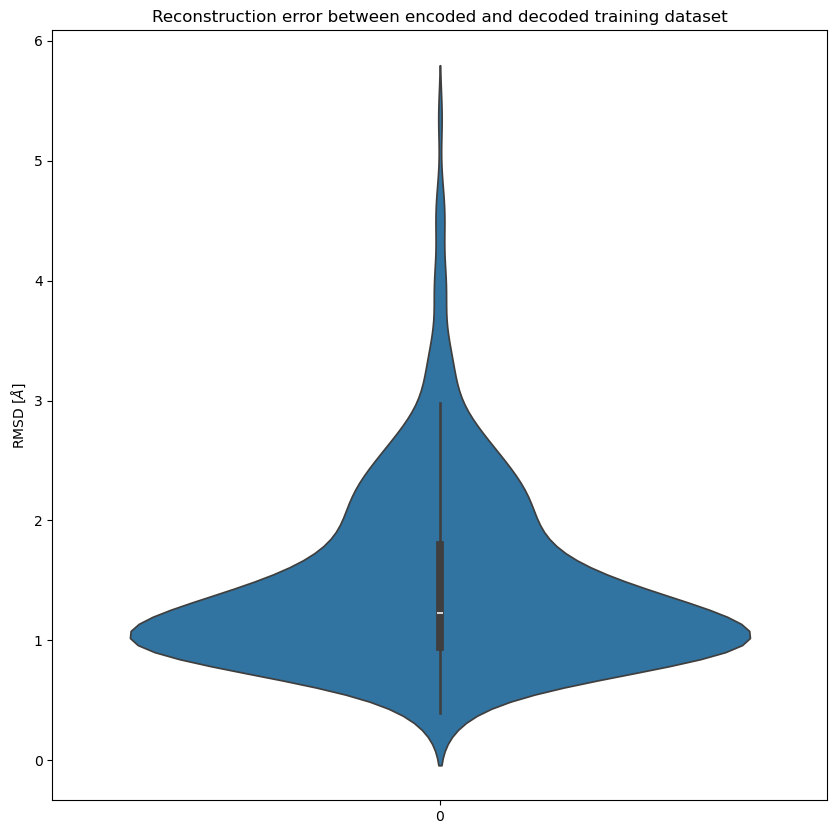

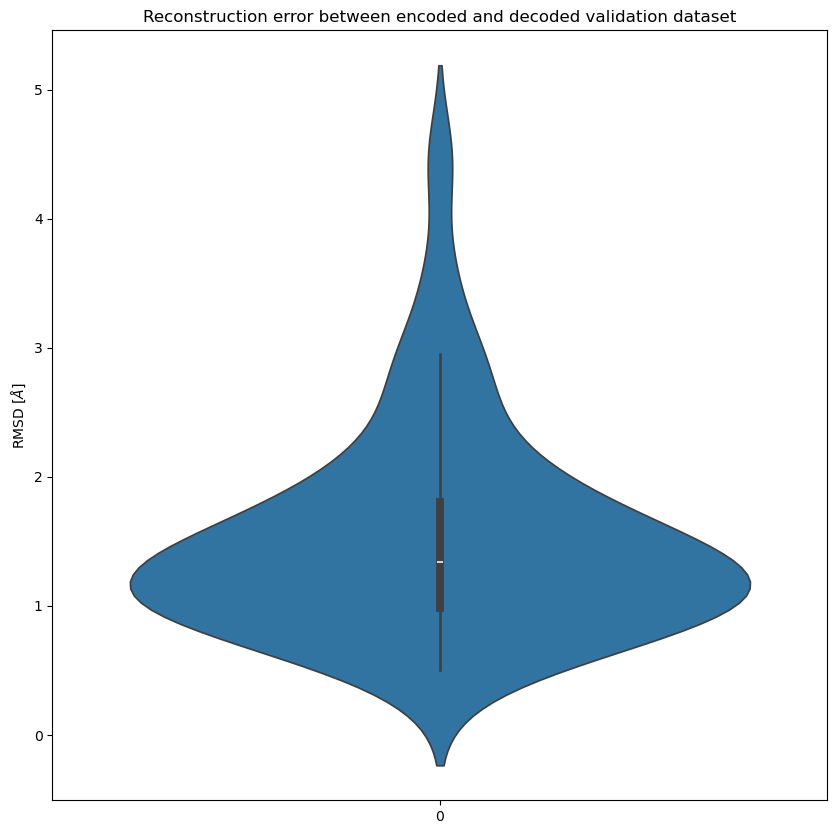

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
data = [err_train]
f = plt.figure(figsize=(10, 10))
sns.violinplot(data)
plt.ylabel('RMSD [$\AA$]')
plt.title('Reconstruction error between encoded and decoded training dataset')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/err_train_{saveName}.png', dpi=300)


data = [err_test]
f = plt.figure(figsize=(10, 10))
sns.violinplot(data)
plt.ylabel('RMSD [$\AA$]')
plt.title('Reconstruction error between encoded and decoded validation dataset')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/err_test_{saveName}.png', dpi=300)

Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/5HHW_A_filled_aligned.pdb -> Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/rmsd_outliers_train/5HHW_A_filled_aligned.pdb
Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/7UY0_A_filled_aligned.pdb -> Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/rmsd_outliers_train/7UY0_A_filled_aligned.pdb
Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/1UA2_A_filled_aligned.pdb -> Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/rmsd_outliers_train/1UA2_A_filled_aligned.pdb
Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial/7KJB_A_filled_aligned.pdb -> Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/rmsd_outliers_train/7KJB_A_filled_aligned.pdb
Copied outlier (valid): Results/run_trial_BRAFActivationLoop_postali

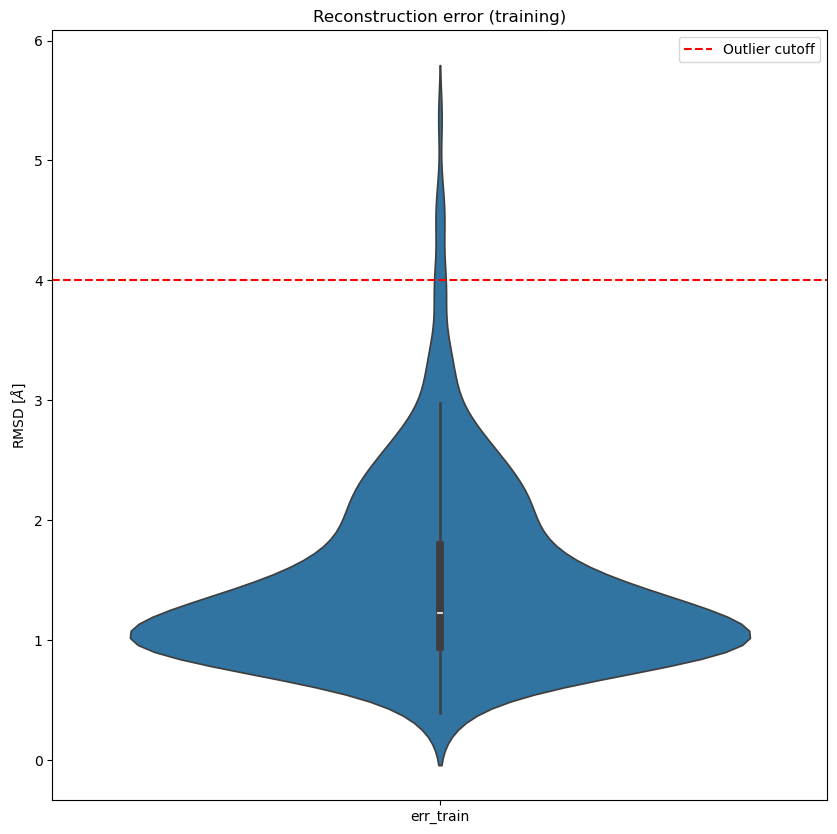

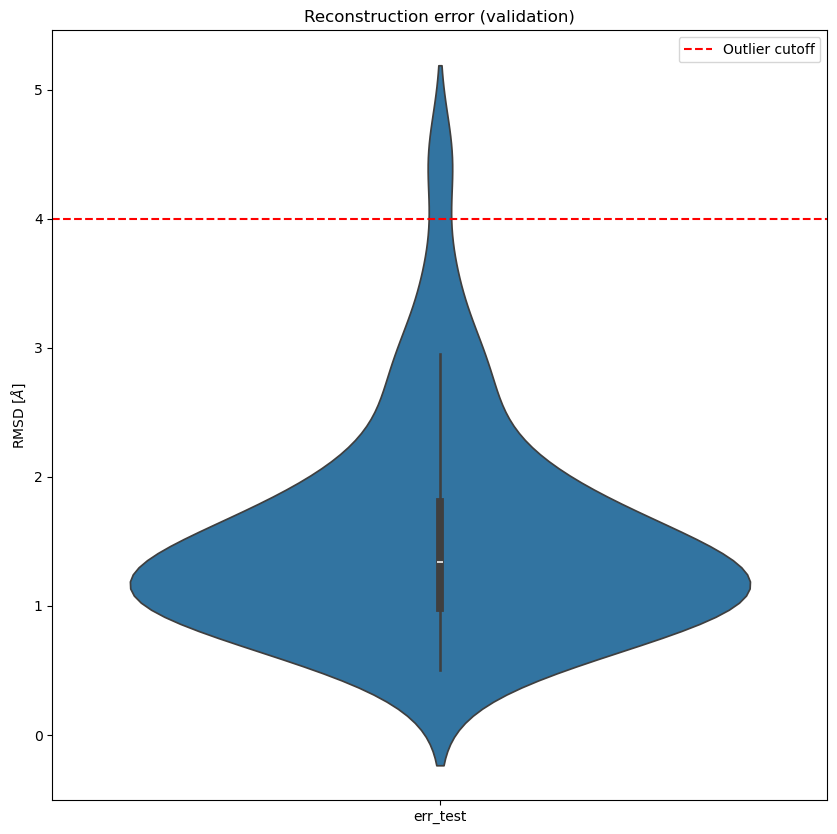

In [64]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Define paths, read in the data
saveName = '_foldingnet_checkpoint'
train_err_csv = f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/err_train_{saveName}.csv'
valid_err_csv = f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/err_valid_{saveName}.csv'

df_err_train = pd.read_csv(train_err_csv)   # columns: ['err_train']
df_err_valid = pd.read_csv(valid_err_csv)   # columns: ['err_test']

# 2) Identify outliers where RMSD > 4
train_outlier_indices = df_err_train.index[df_err_train['err_train'] > 4].to_list()
valid_outlier_indices = df_err_valid.index[df_err_valid['err_test'] > 4].to_list()

# 3) Gather original filenames and the directories containing your re-labeled PDBs
#    - "files": the sorted list of PDB filenames from the original folder 
#               (the same you used to create combined.pdb, excluding 'combined.pdb').

folder_name = 'Results/fitted_matlab_segments/mustangs_endsRealignment_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

#    - "train_indices" (and possibly "valid_indices") map each row in df_err_train/df_err_valid 
#      to the correct frame index. For simple splits, you might only need train_indices 
#      if you used data.split() from your PDBData object. (Adjust this code if valid set 
#      also has a separate set of indices or if you used a different approach.)
# Suppose something like:
# train_indices, valid_indices = data.get_datasets_indices(manual_seed=25)
# or similar. Make sure these match the order used in MA.get_error('training') and .get_error('validation').

# 4) Create output folders for outliers
outlier_dir_train = 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/rmsd_outliers_train'
outlier_dir_valid = 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/rmsd_outliers_valid'
os.makedirs(outlier_dir_train, exist_ok=True)
os.makedirs(outlier_dir_valid, exist_ok=True)

# 5) Copy outlier files for training
source_dir_train = 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial'
for row_i in train_outlier_indices:
    frame_idx = train_indices[row_i]          # The actual frame index
    original_filename = files[frame_idx]      # The original PDB name

    src = os.path.join(source_dir_train, original_filename)
    dst = os.path.join(outlier_dir_train, original_filename)

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f'Copied outlier (train): {src} -> {dst}')
    else:
        print(f'Skipping missing file (train): {src}')

# 6) Copy outlier files for validation
#    If valid set also uses a "valid_indices" array, map row_i -> valid_indices[row_i] -> files[...].
#    If you used a single "indices" array and just split it, adjust accordingly.
source_dir_valid = 'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/getDatasetTrial'
for row_i in valid_outlier_indices:
    frame_idx = valid_indices[row_i]
    original_filename = files[frame_idx]

    src = os.path.join(source_dir_valid, original_filename)
    dst = os.path.join(outlier_dir_valid, original_filename)

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f'Copied outlier (valid): {src} -> {dst}')
    else:
        print(f'Skipping missing file (valid): {src}')

# 7) Plot RMSD for training with a red dotted cutoff line at 4 Å
f = plt.figure(figsize=(10, 10))
sns.violinplot(data=[df_err_train['err_train']])
plt.axhline(y=4.0, color='red', linestyle='--', label='Outlier cutoff')
plt.legend()
plt.ylabel('RMSD [$\\AA$]')
plt.title('Reconstruction error (training)')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/err_train_{saveName}.png', dpi=300)

# 8) Plot RMSD for validation with a red dotted cutoff line at 4 Å
f = plt.figure(figsize=(10, 10))
sns.violinplot(data=[df_err_valid['err_test']])
plt.axhline(y=4.0, color='red', linestyle='--', label='Outlier cutoff')
plt.legend()
plt.ylabel('RMSD [$\\AA$]')
plt.title('Reconstruction error (validation)')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/err_test_{saveName}.png', dpi=300)


In [65]:
MA.setup_grid(30)
landscape_err_latent, landscape_err_3d, xaxis, yaxis = MA.scan_error()
df_landscape_err_latent = pd.DataFrame(landscape_err_latent)
df_landscape_err_latent.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_err_latent_{saveName}.csv', index=False)
'''
df= pd.read_csv(f'landscape_err_latent_{saveName}.csv')
print(df.shape)
'''

df_landscape_err_3d = pd.DataFrame(landscape_err_3d)
df_landscape_err_3d.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_err_3d_{saveName}.csv', index=False)

df_xaxis = pd.DataFrame(xaxis)
df_xaxis.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_err_xaxis_{saveName}.csv', index=False)

df_yaxis = pd.DataFrame(yaxis)
df_yaxis.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_err_yaxis_{saveName}.csv', index=False)

Decoding grid_decoded: 100%|██████████| 113/113 [00:00<00:00, 226.71it/s]


In [ ]:
from molearn.analysis import MolearnGUI
MolearnGUI(MA);

Projection into latent space.

In [66]:
with torch.no_grad():
    z = net.encode(data_train.float())

z_training = z.data.cpu().numpy()[:, :, 0]
df_z_train = pd.DataFrame(z_training)
df_z_train.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_encoded_train_coordinates.csv', index=False)

In [67]:
with torch.no_grad():
    z = net.encode(data_valid.float())
z_valid = z.data.cpu().numpy()[:, :, 0]
df_z_valid = pd.DataFrame(z_valid)
df_z_valid.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_encoded_valid_coordinates.csv', index=False)

Show landscapes.

In [68]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from numpy.linalg import inv

x_file = glob("Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_err_xaxis__foldingnet_checkpoint.csv")
y_file = glob("Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_err_yaxis__foldingnet_checkpoint.csv")
z_file = glob("Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_err_latent__foldingnet_checkpoint.csv")

encoded_train_file = glob("Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_encoded_train_coordinates.csv")
encoded_valid_file = glob("Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/landscape_encoded_valid_coordinates.csv")

df_x = [pd.read_csv(file, header=None).to_numpy() for file in x_file]
df_y = [pd.read_csv(file, header=None).to_numpy() for file in y_file]
df_z = [pd.read_csv(file).to_numpy() for file in z_file]
# Need fliplr because heatmap displays data differently from how array stores it
df_z=np.squeeze(np.fliplr(df_z))

df_encoded_train = [pd.read_csv(file, header=None).to_numpy() for file in encoded_train_file]
df_encoded_valid = [pd.read_csv(file, header=None).to_numpy() for file in encoded_valid_file]

x_encoded_train = [array[:, 0] for array in df_encoded_train]
y_encoded_train = [array[:, 1] for array in df_encoded_train]
x_encoded_valid = [array[:, 0] for array in df_encoded_valid]
y_encoded_valid = [array[:, 1] for array in df_encoded_valid]

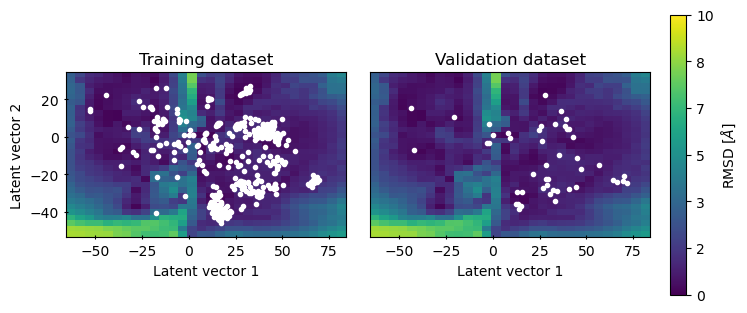

In [82]:
fig = plt.figure(figsize=(8, 8))

# Create 2 square subplots 
# Specify the position of the subplots in the figure
ax1 = fig.add_axes([0.0, 0.1, 0.35, 0.35])
ax1.imshow(df_z, cmap='viridis', vmin=0., vmax=10., extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax1.scatter(x_encoded_train, y_encoded_train, color='white', marker='.')

ax2 = fig.add_axes([0.38, 0.1, 0.35, 0.35])
ax2.imshow(df_z, cmap='viridis', vmin=0., vmax=10., extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax2.scatter(x_encoded_valid, y_encoded_valid, color='white', marker='.')

# Create 2 vertical colorbar axes for the subplots
# Specify the position of the colorbar axes relative to the subplots
cbar_ax2 = fig.add_axes([0.755,0.1,0.02,0.35])
cbar_ax2.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom = False)

# Create colorbar
cbar = fig.colorbar(im, cax=cbar_ax2, label='RMSD [$\AA$]')
cbar_ticks = np.linspace(0, 10, 7)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in cbar_ticks])

# Set axes properties
ax1.tick_params(direction='inout', labelbottom=True, top=False, bottom=True)
ax2.tick_params(direction='inout', labelbottom=True, top=False, bottom=True, left=False, labelleft=False)

# Set labels
ax1.set_xlabel('Latent vector 1')
ax1.set_ylabel('Latent vector 2')
ax2.set_xlabel('Latent vector 1')

#Set titles
ax1.set_title('Training dataset')
ax2.set_title('Validation dataset')

plt.savefig('Results/run_trial_BRAFActivationLoop_postalign_checkpoint1/RMSDlandscapesOnePlot.png', dpi=300, bbox_inches='tight')
plt.show()

Molearn step for secondary structure realignment.

In [ ]:
if __name__ == '__main__':

    data = PDBData()
    folder_name = 'Results/fitted_matlab_segments/mustangs_conserved_secondary_noOutliers'

    # Get a sorted list of all files in the directory, EXCLUDING combined.pdb
    files = sorted([
        f for f in os.listdir(folder_name) 
        if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
    ])

    combined_file_path = os.path.join(folder_name, 'combined.pdb')

    # Open in write mode to overwrite or create a fresh combined.pdb
    with open(combined_file_path, 'w') as combined_file:
        for i, filename in enumerate(files):
            file_path = os.path.join(folder_name, filename)

            # Read content while filtering out lines starting with "MODEL" or "END"
            with open(file_path, 'r') as file:
                lines = file.readlines()
                lines = [line for line in lines if not line.startswith(("MODEL", "END"))]

            # Write "MODEL i", then filtered lines, then "ENDMDL"
            combined_file.write(f'MODEL {i}\n')
            combined_file.writelines(lines)
            combined_file.write('ENDMDL\n')
        
        combined_file.write('END\n')

    # Now import combined.pdb without having to delete it each run
    data.import_pdb(filename=combined_file_path)
    data.fix_terminal()
    data.atomselect(atoms=['CA', 'C', 'N', 'CB', 'O'])
    data.prepare_dataset()
    print(data._mol)

    ##### Prepare Trainer #####
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainer = Trainer(device=device)
    trainer.set_data(data, batch_size=8, validation_split=0.1, manual_seed=25)
    trainer.set_autoencoder(Small_AutoEncoder, out_points=data.dataset.shape[-1])
    trainer.prepare_optimiser()

    ##### Training Loop #####
    # Keep training until loss does not improve for 32 consecutive epochs
    runkwargs = dict(
        log_filename='log_file.dat',
        log_folder='Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/xbb_foldingnet_checkpoints',
        checkpoint_folder='Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1',
    )
    best = 1e24
    while True:
        trainer.run(max_epochs=32 + trainer.epoch, **runkwargs)
        if not best > trainer.best:
            break
        best = trainer.best
    print(f'best {trainer.best}, best_filename {trainer.best_name}')

In [45]:
import molearn
from molearn.analysis.analyser import MolearnAnalysis
from molearn.data import PDBData
from molearn.models.small_foldingnet import Small_AutoEncoder

import pandas as pd

import torch
from copy import deepcopy
import biobox as bb
import numpy as np
import glob as glob

import MDAnalysis as mda
file_pattern = 'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/checkpoint*.ckpt'

print(glob.glob(file_pattern))
# Get a sorted list of all matching checkpoint files
matching_files = sorted(glob.glob(file_pattern))

# Check if we found any matches
if len(matching_files) == 0:
    raise FileNotFoundError(f"No files matched the pattern: {file_pattern}")

# Example 1: Grab the first matching file
networkfile = matching_files[0]

# Example 2 (Alternative): Grab the last matching file (e.g., if it’s the most recent)
# networkfile = matching_files[-1]

# Load the checkpoint
checkpoint = torch.load(networkfile, map_location=torch.device('cpu'))
net = Small_AutoEncoder(**checkpoint['network_kwargs'])
net.load_state_dict(checkpoint['model_state_dict'])

# Print some info
print("Matched files:", matching_files)
print("Using file:", networkfile)
print("Network kwargs:", checkpoint['network_kwargs'])

['Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/checkpoint_epoch522_loss0.0028315518132370453.ckpt']
Matched files: ['Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/checkpoint_epoch522_loss0.0028315518132370453.ckpt']
Using file: Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/checkpoint_epoch522_loss0.0028315518132370453.ckpt
Network kwargs: {'out_points': 27}


In [46]:
import os
data = PDBData()
folder_name = 'Results/fitted_matlab_segments/mustangs_conserved_secondary_noOutliers'
combined_file_path = os.path.join(folder_name, 'combined.pdb')
data.import_pdb(filename=combined_file_path)
#data.import_pdb(f'data{os.sep}MurD_open_selection.pdb')
data.fix_terminal()
data.atomselect(atoms = ['CA', 'C', 'N', 'CB', 'O'])
data.prepare_dataset()

Dataset shape: torch.Size([464, 3, 27])
mean: 111.26907935047109
 std: 20.477224696658045


In [47]:
MA = MolearnAnalysis()
MA.set_network(net)
data_train, data_valid = data.split(manual_seed=25)
MA.set_dataset("training", data_train)
MA.set_dataset("validation", data_valid)

In [48]:
def ifnotmake(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    return dir_path
data_train, data_valid = data.get_datasets(manual_seed=25)

indices = data.indices.numpy()

print(indices)

print(np.shape(data_train)[0])

train_indices = indices[:np.shape(data_train)[0]]
valid_indices = indices[:np.shape(data_valid)[0]]

print(train_indices)

print(np.shape(data_train.numpy()))
ifnotmake('Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial/')
for i, index in enumerate(train_indices):

    print(index)

    data._mol.trajectory[index]  # Set the trajectory to the specific frame

    data._mol.select_atoms("name CA").write(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial/s{i}.pdb')

[324 256 326 337 141 363 455 153 436 208 297 110 440 460 323 299 367 134
 463 111 187  16  98 233 195 106 321 246 329 339  67 410 415 193  96 112
 201 352  89 408  26 441 184  45 167 164 437 300 331   2 458 283 340 248
 308 338  80 312 396  92  12  53 241  23  38 137 450  74 158 231 424 366
 132 278 288 369  49 371 221 261 423 414  75 330 431 229 400 250 126 258
 361 336 358  66 327 235 237 128 444 163 422 196 334 409   0 301 427  10
  48 212 199 402 383 356 377 306 388 245 307 311 459 268 429  55  77  61
 406 461 263 204 216 113 247 435 131 107  95 420  94 124 118 417 451 136
 152  28 170 319 243 282 426 267 265 404  86 322 100  82 335 293 138 234
 161 135 224 156 354  58 251 447 186 174 121  46  76  71 123 442 133  69
 448  91  88 353 217  59  19  65 294  22 182 284 147 244 316 285   7  52
 190 249 359 226 387 105   8  51 342 425 304 120 228 172 393  70 183 270
 144  36 411  14 102 209 155 272 115 443 214 372 145 254 179 355 197 295
  47 292 148 262   9 403 180  13 149 159 456 222  6

In [49]:
directory_name = 'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/decoded_train'

ifnotmake(directory_name)
# Use generate method which is public (no underscore)

latent_coords = MA.get_encoded('training')  # Example latent space coordinates

#print(np.shape(np.squeeze(latent_coords.numpy())))

crd_ref = MA.generate(latent_coords.numpy().reshape(1, len(latent_coords), 2), directory_name, relax=False)

Generating pdb file: 100%|██████████| 418/418 [00:00<00:00, 1212.30it/s]


In [52]:
import os
import re
import MDAnalysis as mda
import MDAnalysis.analysis.rms as rms

# Directories
getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial/'
decoded_train_dir = 'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/decoded_train'

# List all files in the directories
getDatasetTrial_files = os.listdir(getDatasetTrial_dir)
decoded_train_files = os.listdir(decoded_train_dir)

# Filter files that start with 's' in decoded_train
decoded_train_files = [f for f in decoded_train_files if f.startswith('s')]

# Function to extract the numerical part from a file name
def extract_number(file_name):
    match = re.search(r'\d+', file_name)
    return int(match.group()) if match else float('inf')

# Sort the file names based on the numerical part
getDatasetTrial_files.sort(key=extract_number)
decoded_train_files.sort(key=extract_number)

# Calculate RMSD for files with the same name
rmsd_values = {}

for file_name in getDatasetTrial_files:
    if file_name in decoded_train_files:
        # Load the universes
        u1 = mda.Universe(os.path.join(getDatasetTrial_dir, file_name))
        u2 = mda.Universe(os.path.join(decoded_train_dir, file_name))
        
        # Select CA atoms
        ag1 = u1.select_atoms("name CA")
        ag2 = u2.select_atoms("name CA")
        
        # Calculate RMSD
        rmsd_value = rms.rmsd(ag1.positions, ag2.positions)
        rmsd_values[file_name] = rmsd_value

# Print RMSD values in sorted order
for file_name in sorted(rmsd_values.keys(), key=extract_number):
    print(f"RMSD for {file_name}: {rmsd_values[file_name]}")


In [51]:
print(list(MA.get_error('training', align=False)))

Decoding training: 100%|██████████| 418/418 [00:00<00:00, 519.01it/s]


[1.1050489567414776, 1.5813083303417972, 1.936881163656153, 1.303289751439117, 1.3536936920239557, 1.5810861088508064, 4.0371664365457525, 1.03473428353627, 1.4152577693391295, 1.6752911687334142, 1.844931550158032, 0.8116258227728883, 2.2093861627324216, 3.292261512542782, 1.3900490217664172, 1.1151662156070508, 1.3926239822523423, 1.4567436636704072, 2.5297656318359274, 0.5010315003820974, 2.026572277034941, 1.0227351389938144, 0.5595693656672229, 1.5362648017679954, 0.8902218943126724, 1.6779056110201525, 2.6613948422112657, 0.6192658346017356, 0.9963697307403754, 1.0133841548690343, 2.4254886188824747, 0.8858043744312091, 0.5559972702475708, 1.8259835157983897, 1.603009135214011, 0.9202629981322388, 3.6282979839212923, 1.3952335821539898, 1.1974315895898542, 1.2901613494790198, 1.261718078130196, 0.9657023446790002, 1.5882537414100004, 1.1320093262428903, 0.9567277145844884, 1.7566087860345445, 1.5754667582834503, 1.3053164071446968, 0.924486502318314, 0.5286410226587354, 4.3423377

Renaming input and decoded datasets with PDB IDs.

In [50]:
import os

# 1) Gather the original files again (same sorting you used earlier):
folder_name = 'Results/fitted_matlab_segments/mustangs_conserved_secondary_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

# 2) Define the directories that have "s{i}.pdb"
getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial'
decoded_train_dir = 'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/decoded_train'

# Suppose you already have train_indices from your dataset split
# (something like train_indices = data.indices.numpy()[:len(data_train)])
# We'll loop over each entry in train_indices:
for i, index in enumerate(train_indices):
    original_filename = files[index]  # the PDB name from the original folder

    # 3) Rename the file in getDatasetTrial:
    old_file_getDataset = os.path.join(getDatasetTrial_dir, f's{i}.pdb')
    new_file_getDataset = os.path.join(getDatasetTrial_dir, original_filename)
    
    if os.path.exists(old_file_getDataset):
        os.rename(old_file_getDataset, new_file_getDataset)
        print(f'Renamed: {old_file_getDataset} -> {new_file_getDataset}')
    else:
        print(f'File not found (skipping): {old_file_getDataset}')

    # 4) Rename the file in decoded_train:
    old_file_decoded = os.path.join(decoded_train_dir, f's{i}.pdb')
    new_file_decoded = os.path.join(decoded_train_dir, original_filename)
    
    if os.path.exists(old_file_decoded):
        os.rename(old_file_decoded, new_file_decoded)
        print(f'Renamed: {old_file_decoded} -> {new_file_decoded}')
    else:
        print(f'File not found (skipping): {old_file_decoded}')

Renamed: Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial/s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial/5L4Q_A_filled.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/decoded_train/s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/decoded_train/5L4Q_A_filled.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial/s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial/4K33_A_filled.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/decoded_train/s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/decoded_train/4K33_A_filled.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial/s2.pdb -> Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getData

In [11]:
MA.batch_size = 8
MA.processes = 4

In [12]:
saveName = '_foldingnet_checkpoint'

#saveName = directory.replace('_foldingnet_checkpoint', '')
err_train = MA.get_error('training')
df_err_train = pd.DataFrame(err_train, columns=['err_train'])
df_err_train.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/err_train_{saveName}.csv', index=False)

err_test = MA.get_error('validation')
df_err_test = pd.DataFrame(err_test, columns=['err_test'])
df_err_test.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/err_valid_{saveName}.csv', index=False)



Decoding validation: 100%|██████████| 6/6 [00:00<00:00, 209.15it/s]


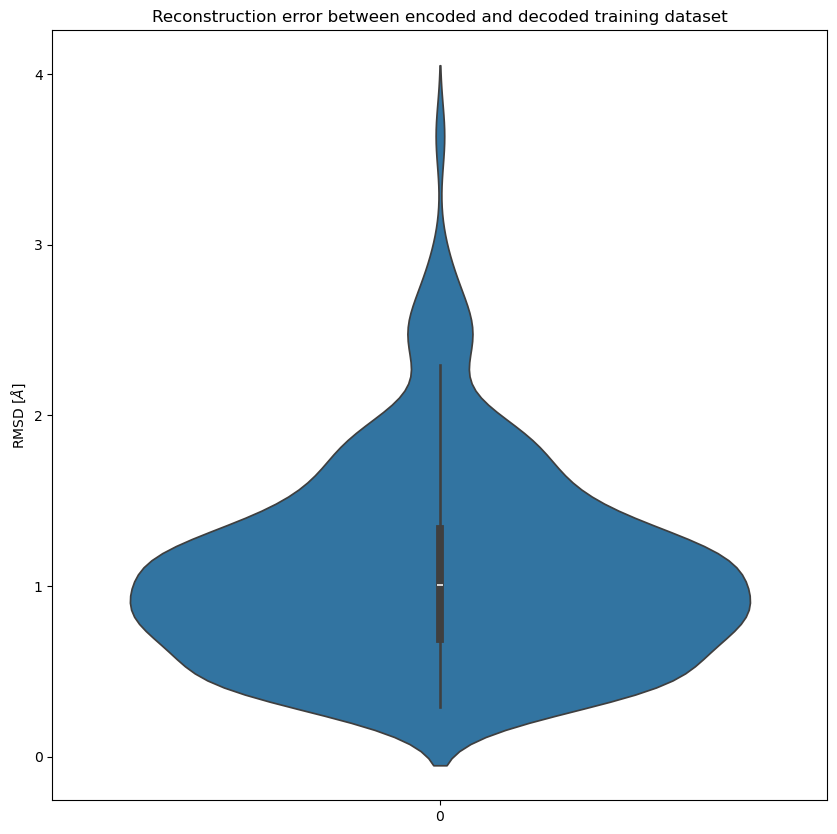

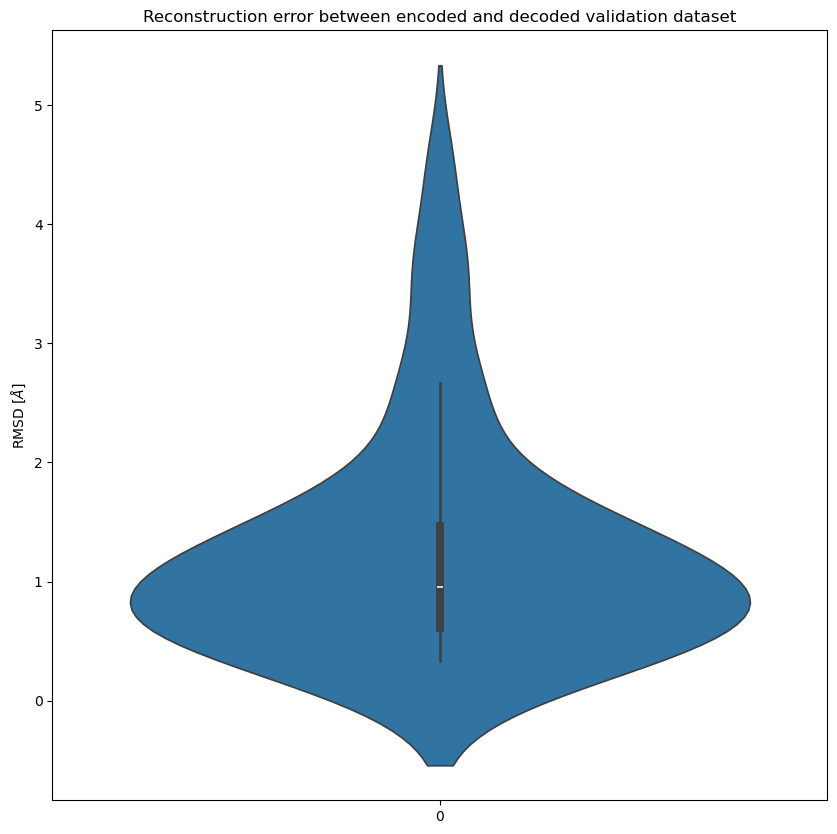

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
data = [err_train]
f = plt.figure(figsize=(10, 10))
sns.violinplot(data)
plt.ylabel('RMSD [$\AA$]')
plt.title('Reconstruction error between encoded and decoded training dataset')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/err_train_{saveName}.png', dpi=300)


data = [err_test]
f = plt.figure(figsize=(10, 10))
sns.violinplot(data)
plt.ylabel('RMSD [$\AA$]')
plt.title('Reconstruction error between encoded and decoded validation dataset')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/err_test_{saveName}.png', dpi=300)

Copied outlier (valid): Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial/5HEZ_A_filled.pdb -> Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/rmsd_outliers_valid/5HEZ_A_filled.pdb


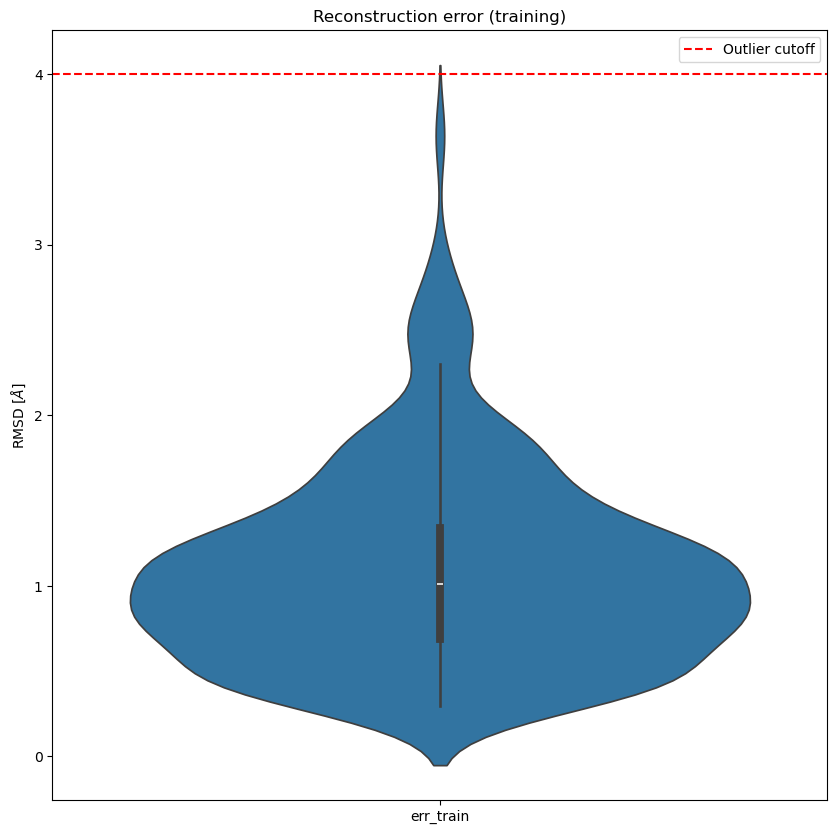

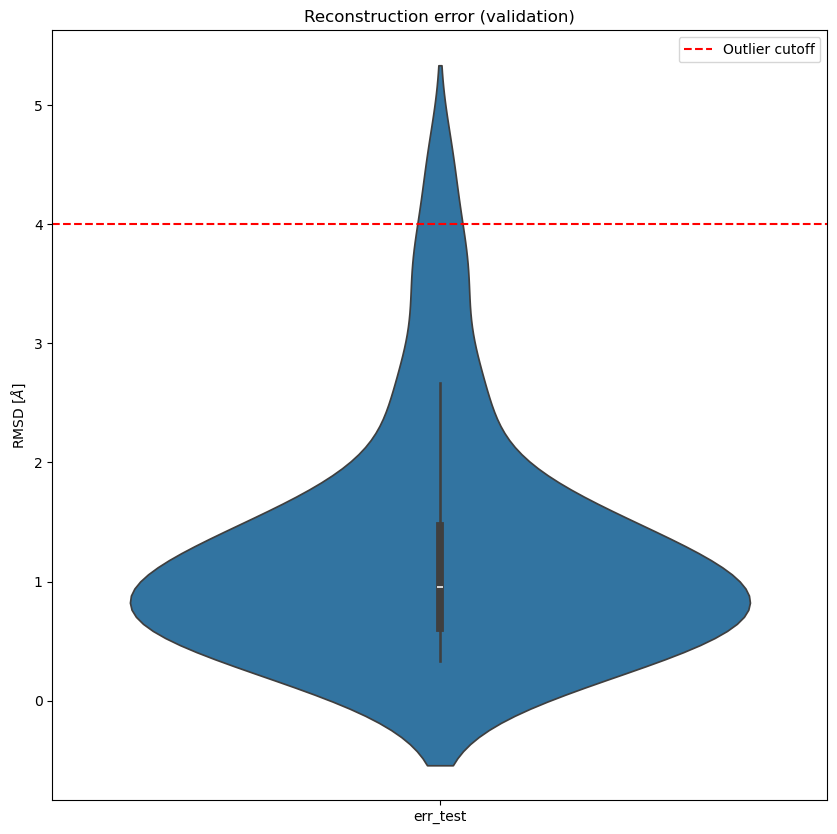

In [14]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Define paths, read in the data
saveName = '_foldingnet_checkpoint'
train_err_csv = f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/err_train_{saveName}.csv'
valid_err_csv = f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/err_valid_{saveName}.csv'

df_err_train = pd.read_csv(train_err_csv)   # columns: ['err_train']
df_err_valid = pd.read_csv(valid_err_csv)   # columns: ['err_test']

# 2) Identify outliers where RMSD > 4
train_outlier_indices = df_err_train.index[df_err_train['err_train'] > 4].to_list()
valid_outlier_indices = df_err_valid.index[df_err_valid['err_test'] > 4].to_list()

# 3) Gather original filenames and the directories containing your re-labeled PDBs
#    - "files": the sorted list of PDB filenames from the original folder 
#               (the same you used to create combined.pdb, excluding 'combined.pdb').

folder_name = 'Results/fitted_matlab_segments/mustangs_conserved_secondary_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

#    - "train_indices" (and possibly "valid_indices") map each row in df_err_train/df_err_valid 
#      to the correct frame index. For simple splits, you might only need train_indices 
#      if you used data.split() from your PDBData object. (Adjust this code if valid set 
#      also has a separate set of indices or if you used a different approach.)
# Suppose something like:
# train_indices, valid_indices = data.get_datasets_indices(manual_seed=25)
# or similar. Make sure these match the order used in MA.get_error('training') and .get_error('validation').

# 4) Create output folders for outliers
outlier_dir_train = 'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/rmsd_outliers_train'
outlier_dir_valid = 'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/rmsd_outliers_valid'
os.makedirs(outlier_dir_train, exist_ok=True)
os.makedirs(outlier_dir_valid, exist_ok=True)

# 5) Copy outlier files for training
source_dir_train = 'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial'
for row_i in train_outlier_indices:
    frame_idx = train_indices[row_i]          # The actual frame index
    original_filename = files[frame_idx]      # The original PDB name

    src = os.path.join(source_dir_train, original_filename)
    dst = os.path.join(outlier_dir_train, original_filename)

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f'Copied outlier (train): {src} -> {dst}')
    else:
        print(f'Skipping missing file (train): {src}')

# 6) Copy outlier files for validation
#    If valid set also uses a "valid_indices" array, map row_i -> valid_indices[row_i] -> files[...].
#    If you used a single "indices" array and just split it, adjust accordingly.
source_dir_valid = 'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/getDatasetTrial'
for row_i in valid_outlier_indices:
    frame_idx = valid_indices[row_i]
    original_filename = files[frame_idx]

    src = os.path.join(source_dir_valid, original_filename)
    dst = os.path.join(outlier_dir_valid, original_filename)

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f'Copied outlier (valid): {src} -> {dst}')
    else:
        print(f'Skipping missing file (valid): {src}')

# 7) Plot RMSD for training with a red dotted cutoff line at 4 Å
f = plt.figure(figsize=(10, 10))
sns.violinplot(data=[df_err_train['err_train']])
plt.axhline(y=4.0, color='red', linestyle='--', label='Outlier cutoff')
plt.legend()
plt.ylabel('RMSD [$\\AA$]')
plt.title('Reconstruction error (training)')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/err_train_{saveName}.png', dpi=300)

# 8) Plot RMSD for validation with a red dotted cutoff line at 4 Å
f = plt.figure(figsize=(10, 10))
sns.violinplot(data=[df_err_valid['err_test']])
plt.axhline(y=4.0, color='red', linestyle='--', label='Outlier cutoff')
plt.legend()
plt.ylabel('RMSD [$\\AA$]')
plt.title('Reconstruction error (validation)')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/err_test_{saveName}.png', dpi=300)


In [15]:
MA.setup_grid(30)
landscape_err_latent, landscape_err_3d, xaxis, yaxis = MA.scan_error()
df_landscape_err_latent = pd.DataFrame(landscape_err_latent)
df_landscape_err_latent.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_err_latent_{saveName}.csv', index=False)
'''
df= pd.read_csv(f'landscape_err_latent_{saveName}.csv')
print(df.shape)
'''

df_landscape_err_3d = pd.DataFrame(landscape_err_3d)
df_landscape_err_3d.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_err_3d_{saveName}.csv', index=False)

df_xaxis = pd.DataFrame(xaxis)
df_xaxis.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_err_xaxis_{saveName}.csv', index=False)

df_yaxis = pd.DataFrame(yaxis)
df_yaxis.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_err_yaxis_{saveName}.csv', index=False)

Decoding grid_decoded: 100%|██████████| 113/113 [00:00<00:00, 261.73it/s]


In [16]:
from molearn.analysis import MolearnGUI
MolearnGUI(MA);

Projection into latent space.

In [33]:
with torch.no_grad():
    z = net.encode(data_train.float())

z_training = z.data.cpu().numpy()[:, :, 0]
df_z_train = pd.DataFrame(z_training)
df_z_train.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_encoded_train_coordinates.csv', index=False)

In [34]:
with torch.no_grad():
    z = net.encode(data_valid.float())
z_valid = z.data.cpu().numpy()[:, :, 0]
df_z_valid = pd.DataFrame(z_valid)
df_z_valid.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_encoded_valid_coordinates.csv', index=False)

Show landscapes.

In [43]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from numpy.linalg import inv

x_file = glob("Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_err_xaxis__foldingnet_checkpoint.csv")
y_file = glob("Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_err_yaxis__foldingnet_checkpoint.csv")
z_file = glob("Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_err_latent__foldingnet_checkpoint.csv")

encoded_train_file = glob("Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_encoded_train_coordinates.csv")
encoded_valid_file = glob("Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/landscape_encoded_valid_coordinates.csv")

df_x = [pd.read_csv(file, header=None).to_numpy() for file in x_file]
df_y = [pd.read_csv(file, header=None).to_numpy() for file in y_file]
df_z = [pd.read_csv(file).to_numpy() for file in z_file]
# Need fliplr because heatmap displays data differently from how array stores it
df_z=np.squeeze(np.fliplr(df_z))

df_encoded_train = [pd.read_csv(file, header=None).to_numpy() for file in encoded_train_file]
df_encoded_valid = [pd.read_csv(file, header=None).to_numpy() for file in encoded_valid_file]

x_encoded_train = [array[:, 0] for array in df_encoded_train]
y_encoded_train = [array[:, 1] for array in df_encoded_train]
x_encoded_valid = [array[:, 0] for array in df_encoded_valid]
y_encoded_valid = [array[:, 1] for array in df_encoded_valid]


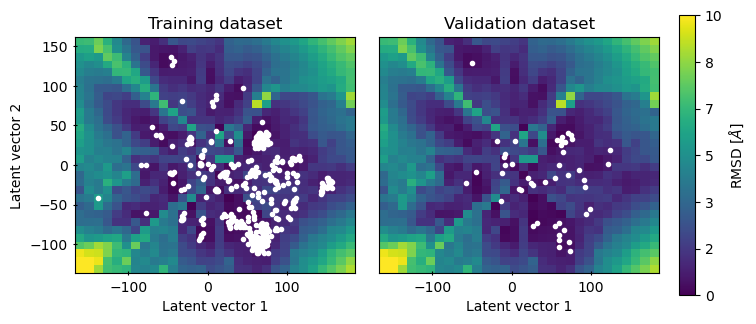

In [44]:
fig = plt.figure(figsize=(8, 8))

# Create 2 square subplots 
# Specify the position of the subplots in the figure
ax1 = fig.add_axes([0.0, 0.1, 0.35, 0.35])
ax1.imshow(df_z, cmap='viridis', vmin=0., vmax=10., extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax1.scatter(x_encoded_train, y_encoded_train, color='white', marker='.')

ax2 = fig.add_axes([0.38, 0.1, 0.35, 0.35])
im = ax2.imshow(df_z, cmap='viridis', vmin=0., vmax=10., extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax2.scatter(x_encoded_valid, y_encoded_valid, color='white', marker='.')

# Create 2 vertical colorbar axes for the subplots
# Specify the position of the colorbar axes relative to the subplots
cbar_ax2 = fig.add_axes([0.755,0.1,0.02,0.35])
cbar_ax2.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom = False)

# Create colorbar
cbar = fig.colorbar(im, cax=cbar_ax2, label='RMSD [$\AA$]')
cbar_ticks = np.linspace(0, 10, 7)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in cbar_ticks])

# Set axes properties
ax1.tick_params(direction='inout', labelbottom=True, top=False, bottom=True)
ax2.tick_params(direction='inout', labelbottom=True, top=False, bottom=True, left=False, labelleft=False)

# Set labels
ax1.set_xlabel('Latent vector 1')
ax1.set_ylabel('Latent vector 2')
ax2.set_xlabel('Latent vector 1')

#Set titles
ax1.set_title('Training dataset')
ax2.set_title('Validation dataset')

plt.savefig('Results/run_trial_BRAFActivationLoop_postalign_secondary_checkpoint1/RMSDlandscapesOnePlot.png', dpi=300, bbox_inches='tight')
plt.show()